<a href="https://colab.research.google.com/github/sk2003hw/Comparison-of-Clustering-Techniques/blob/main/MATH572_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MATH572: Comparing Clustering Algorithms

In [ ]:
!pip install clusteval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 4.8 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries and functions
import pandas as pd
import numpy as np
import copy
import random
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.neighbors import LocalOutlierFactor,  NearestNeighbors
from clusteval import clusteval
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy import linalg

## Data Loading

In [ ]:
data = pd.read_csv("https://russellmilne.com/teaching/gvrd-rangestd.csv", header=None) # loading the data into a dataframe
print(data.head()) # glimpse of the data

data = data.T # transposing as observations are in rows and features in rows
print("Dimensions of the dataset: ", data.shape)
print('*'*100)
print(data.describe()) # glimpse of the data
print('*'*100)

print("Columns/Features: ",data.columns)
print("\nDataframe information:")
data.info()

        0         1         2         3         4         5         6    \
0  0.048734  0.111323  0.064023  0.058767  0.050645  0.043000  0.044434   
1  0.156177  0.074072  0.080148  0.131366  0.147004  0.173057  0.104412   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.504464  0.571429  0.473214  0.410714  0.446429  0.602679  0.504464   
4  0.393617  0.606383  0.489362  0.414894  0.489362  0.553191  0.489362   

        7         8         9    ...       449       450       451       452  \
0  0.093645  0.041567  0.056378  ...  0.140468  0.056856  1.000000  0.128046   
1  0.079996  0.120856  0.134096  ...  0.038756  0.089688  0.028352  0.032579   
2  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
3  0.321429  0.535714  0.250000  ...  0.910714  0.758929  0.883929  0.924107   
4  0.340426  0.446809  0.361702  ...  0.819149  0.744681  0.925532  0.659574   

        453       454       455       456       457       458  
0  0

In [ ]:
print("Null values: ", data.isna().sum().sum()) # checling for null values
print("Number of duplicates: ", data.duplicated().sum()) # checking for duplicates

Null values:  0
Number of duplicates:  0


In [ ]:
# to check need for standardization as uptil now, there does not seem to be any need
# if needed, the below commented code could be run
# scaled_data = StandardScaler().fit_transform(data) # to standardize the features
# data = pd.DataFrame(scaled_data, columns=data.columns) # converting the scaled data into a dataframe from an array

print("All minimums are less than 1: ",(data.min()<1).all()) # minimum is 0 and all minimums are checked to be less than 1
print("All maximums are less than or equal to 1: ",(data.max()<=1).all()) # all maximums are checked to be less than or equal to 1
# Both are True so no scaling is needed

All minimums are less than 1:  True
All maximums are less than or equal to 1:  True


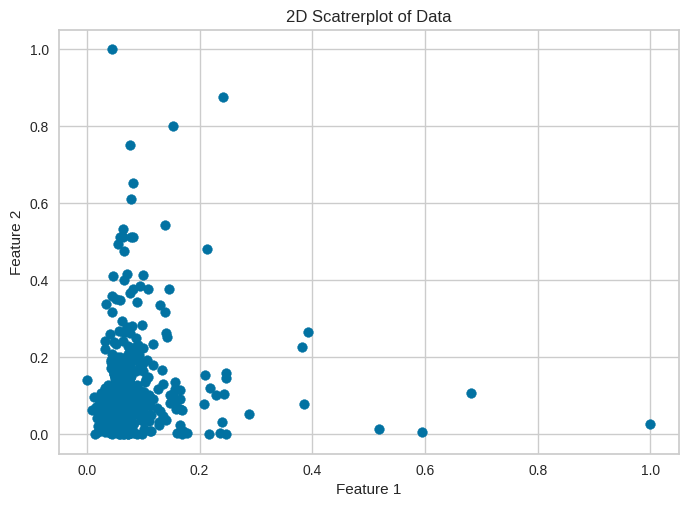

In [ ]:
plt.scatter(data.iloc[:, 0], data.iloc[:, 1]) # for naively visualizing the entire data in 2 dimensional space
plt.title('2D Scatrerplot of Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Principal Component Analysis

In [ ]:
pca = PCA(n_components=3) # PCA object instantiated with 3 components as in project
reduced_data = pca.fit_transform(data) # principal component analysis on the data; fit model and reduce dimensions

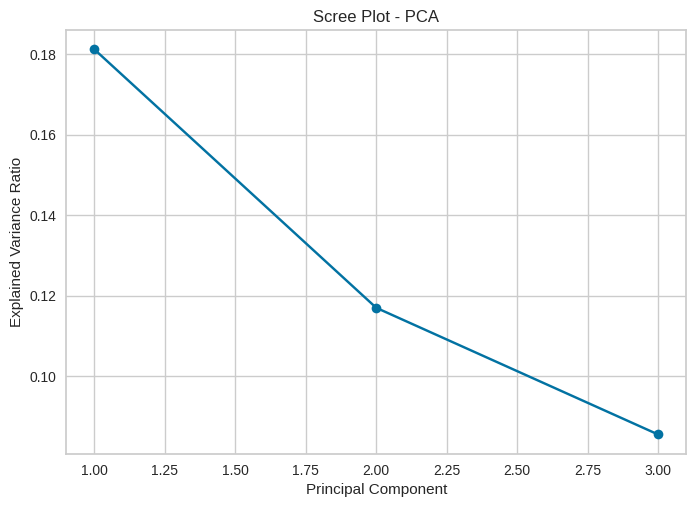

In [ ]:
# scree plot
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - PCA')
plt.show()

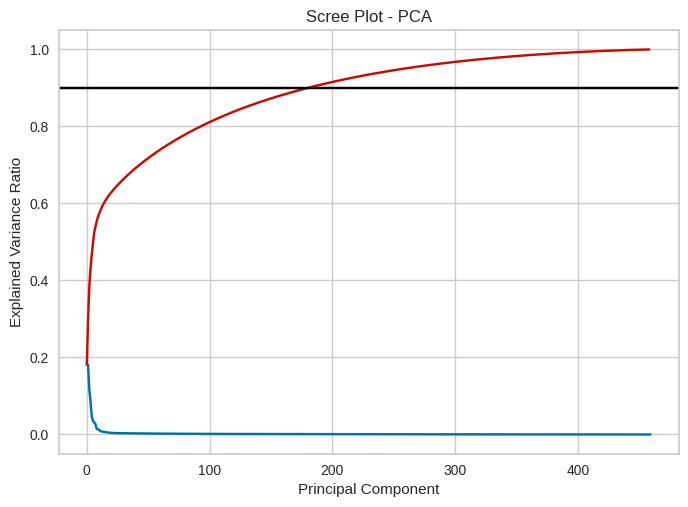

In [ ]:
# PCA is instantiated again without any configuration to see how many principal compoents would be ideal
pca1 = PCA()
pca1.fit_transform(data)
explained_variance_ratio = pca1.explained_variance_ratio_ # proportion of the total variance in the data explained by first 50 principal components
cum_var = np.cumsum(explained_variance_ratio) # cumulative (summed) explained variance
# represents the number of principal components surpassing the threshold
num_components = np.sum(cum_var >= 0.9)

# scree plot to see how many PCs to select, not much difference is found
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'b-')
plt.plot(np.arange(len(explained_variance_ratio)), cum_var, 'r-')
plt.axhline(0.9, label='90% threshold', color='black') # to mark the 90% threshold
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - PCA')
plt.show()

In [ ]:
reduced_data = pd.DataFrame(reduced_data) # converting to a dataframe

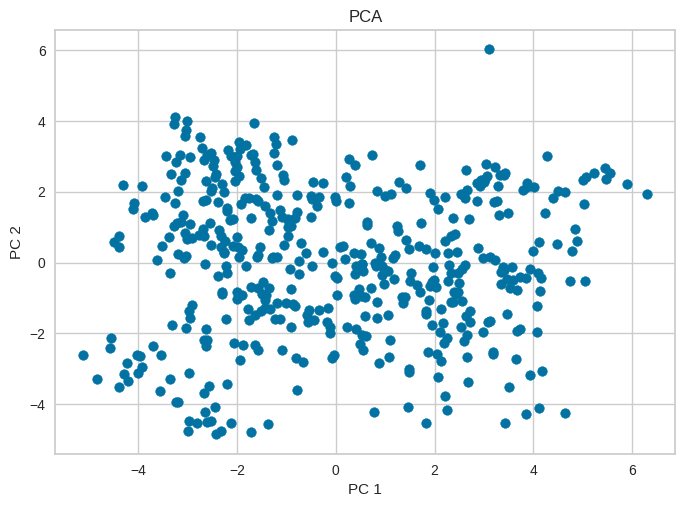

In [ ]:
# Scatter plot with the reduced data
plt.scatter(reduced_data.iloc[:, 0], reduced_data.iloc[:, 1]) # for the data
plt.title(f'PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

## Using t-SNE (t-distributed Stochastic Neighbor Embedding)

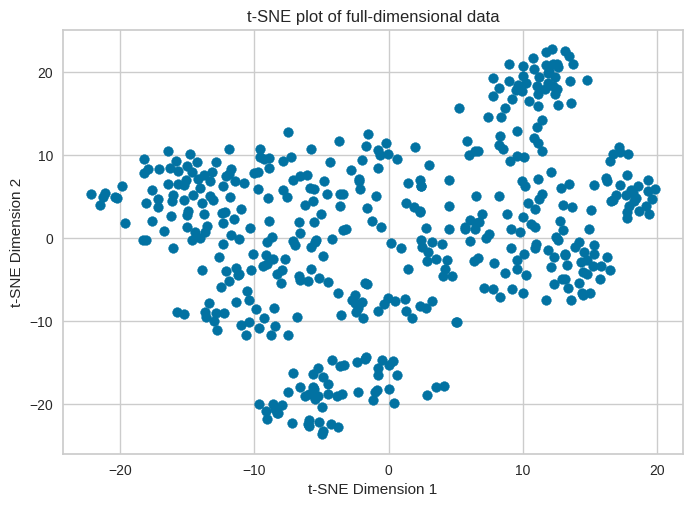


 KL divergence score:  0.7379979491233826


In [ ]:
# t-sne to find clusters in high-dimensional datasets
tsne_obj = TSNE(n_components=2, n_iter=2000, random_state=0) # n_components parameter=2 for a 2D representation, random_state for reproducibility of the run
# n_iter is the number of iterations to run the algorithm for
tsne = tsne_obj.fit_transform(data) # applying t-sne on the original data for a reduced-dimensional dataset
tsne = pd.DataFrame(tsne)

# Plotting the t-sne results
plt.scatter(tsne.iloc[:, 0], tsne.iloc[:, 1]) # both the tsne dimensions
plt.title('t-SNE plot of full-dimensional data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

print("\n KL divergence score: ", tsne_obj.kl_divergence_)

Text(0, 0.5, 'Divergence')

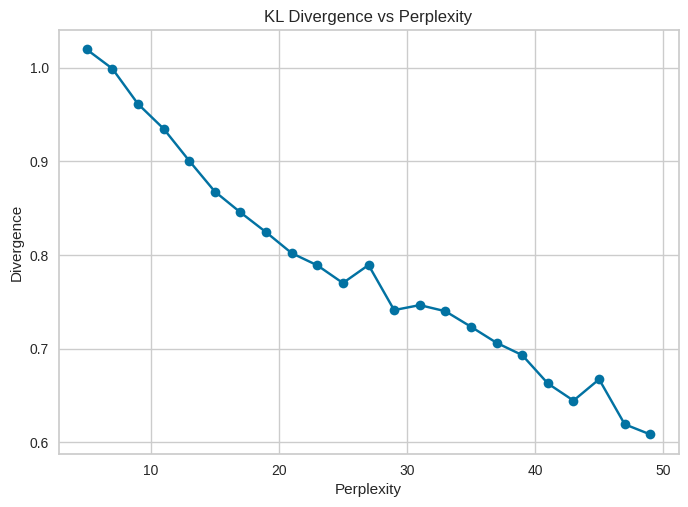

In [ ]:
perplexity = np.arange(5, 50, 2) # range of perplexities
divergence = [] # to store KL divergence values
for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i) # T-SNE model is fit with type pca to initially start with pca type reduction
    reduced = model.fit_transform(data)
    divergence.append(model.kl_divergence_)

plt.plot(perplexity, divergence, 'bo-')
plt.title("KL Divergence vs Perplexity")
plt.xlabel("Perplexity")
plt.ylabel("Divergence")

In [ ]:
# t-sne to find clusters in high-dimensional datasets
tsne_obj = TSNE(n_components=2, n_iter=2000, random_state=0, perplexity=40) # n_components parameter=2 for a 2D representation, random_state for reproducibility of the run
# n_iter is the number of iterations to run the algorithm for
tsne = tsne_obj.fit_transform(data) # applying t-sne on the original data for a reduced-dimensional dataset
tsne = pd.DataFrame(tsne)

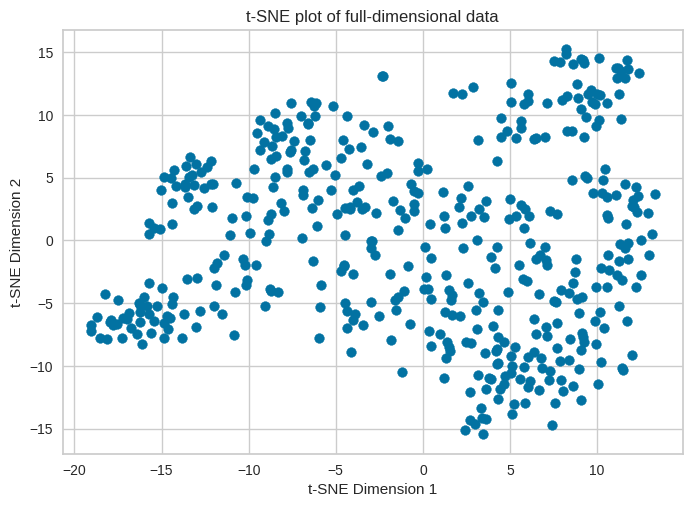

KL divergence score:  0.6553380489349365


In [ ]:
# t-sne to find clusters in high-dimensional datasets
tsne_obj = TSNE(n_components=2, n_iter=2000, random_state=0, perplexity=40) # n_components parameter=2 for a 2D representation, random_state for reproducibility of the run
# n_iter is the number of iterations to run the algorithm for
tsne = tsne_obj.fit_transform(data) # applying t-sne on the original data for a reduced-dimensional dataset
tsne = pd.DataFrame(tsne)

# Plotting the t-sne results
plt.scatter(tsne.iloc[:, 0], tsne.iloc[:, 1]) # both the tsne dimensions
plt.title('t-SNE plot of full-dimensional data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

print("KL divergence score: ", tsne_obj.kl_divergence_)

In [ ]:
print("Dimensions of original dataset: ",data.shape)
print("\nDimensions of PCA-reduced dataset: ",reduced_data.shape)
print("\nDimensions of t-SNE-reduced dataset: ",tsne.shape)

Dimensions of original dataset:  (459, 2207)

Dimensions of PCA-reduced dataset:  (459, 3)

Dimensions of t-SNE-reduced dataset:  (459, 2)


## Comparing K-Means Clustering on Original and Reduced-dimensional Dataset   
Reduced-dimensional dataset has been obtained from principal component analysis

### Clustering with randomly-initialized k value

In [ ]:
# Running k-means clusering on the dataset with a randomly assigned initial number of clusters
k1 = 5 # number of clusters
kmeans1 = KMeans(n_clusters=k1, random_state=0, n_init=10)
kmeans1.fit(data) # fitting a k-means model; running the algorithm on this data.
clusters_original = kmeans1.labels_ # clusters assgined to the data points
print("Uniue cluster labels: ",np.unique(clusters_original))
print("\nCluster counts:\n",pd.Series(clusters_original).value_counts())

n = data.shape[0] # number of rows/observations
M = np.zeros((n, n)) # M matrix with all 0s

# to populate M with 1 if observations at i and j are in the same cluster and 0 is left if they are in different clusters
for i in range(n):
    for j in range(n):
        if clusters_original[i] == clusters_original[j]:
            M[i][j] = 1

Uniue cluster labels:  [0 1 2 3 4]

Cluster counts:
 1    159
2    118
0    106
3     75
4      1
dtype: int64


In [ ]:
k2 = 5 # number of clusters
kmeans2 = KMeans(n_clusters=k2, random_state=0, n_init=10)
clusters_reduced = kmeans2.fit_predict(reduced_data) # the new clusters lables assigned
print("Uniue cluster labels: ",np.unique(clusters_original))
print("\nNew cluster counts:\n",pd.Series(clusters_reduced).value_counts())

P = np.zeros((n, n))
# to populate P with 1 if observations at i and j are in the same cluster and 0 is left if they are in different clusters
for i in range(n):
    for j in range(n):
        if clusters_reduced[i] == clusters_reduced[j]:
            P[i][j] = 1

# checking the number of matching cluster assignments from M and P
matches = np.sum(M == P)
print("Number of matching cluster assignments between M and P:", matches)
print("Percentage of matching cluster assignments = ", round(matches/(n*n) * 100,2))

Uniue cluster labels:  [0 1 2 3 4]

New cluster counts:
 1    121
0    114
4     93
2     69
3     62
dtype: int64
Number of matching cluster assignments between M and P: 188301
Percentage of matching cluster assignments =  89.38


Silhouette coefficient: 0.12321982137533422
outliers in cluster 0 : []
outliers in cluster 1 : []
outliers in cluster 2 : [95]
outliers in cluster 3 : [97]
outliers in cluster 4 : [369]


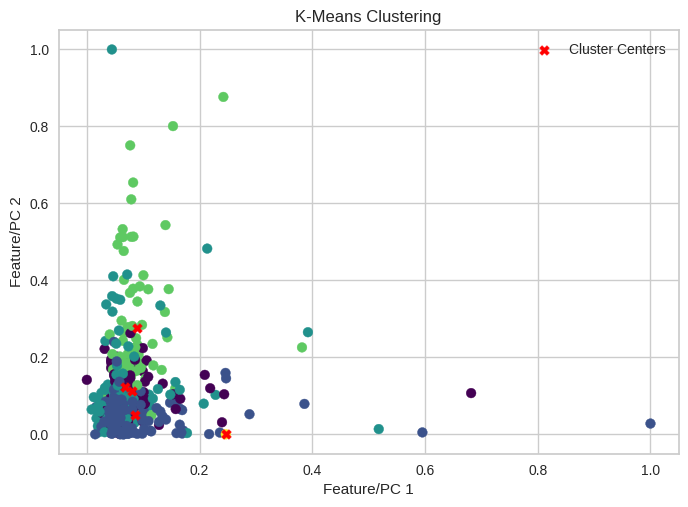

In [ ]:
def testingfunc (data1, clusters, cluster_centers, k1):
  """
    Testing the clustering algorithms' outputs on a dataset
  """
  silhouette = silhouette_score(data1, clusters) # silhoutte score of the clustering on the dataset
  print("Silhouette coefficient:", silhouette)

  outlier_score = LocalOutlierFactor().fit_predict(data1) # outlier detection in the clusters
  # to find the number of outliers in each of the clusters
  for cluster in range(k1):
    cluster_indices = np.where(clusters_original == cluster)[0]
    cluster_outlier_score = outlier_score[cluster_indices]
    outliers = cluster_indices[cluster_outlier_score == -1]
    print("outliers in cluster", cluster, ":", outliers)

  # Scatter plot with data by only the first 2 features/dimensions or principal components and the cluster centers
  plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], c=clusters, cmap='viridis') # for the data
  plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X', label='Cluster Centers') # for the cluster centres
  plt.title(f'K-Means Clustering')
  plt.xlabel('Feature/PC 1')
  plt.ylabel('Feature/PC 2')
  plt.legend()
  plt.show()

testingfunc(data, clusters_original, kmeans1.cluster_centers_, k1)

Silhouette coefficient: 0.3210232689650227
outliers in cluster 0 : []
outliers in cluster 1 : []
outliers in cluster 2 : []
outliers in cluster 3 : []
outliers in cluster 4 : [369]


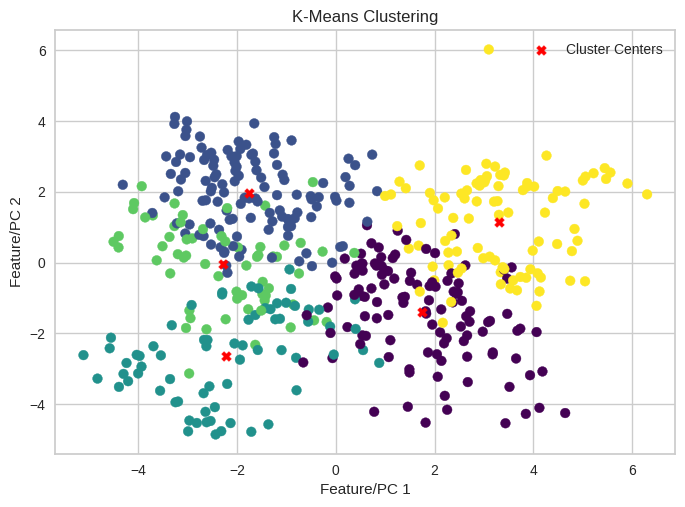

Adjusted Rand Score: 0.7075796543536049


In [ ]:
testingfunc(reduced_data, clusters_reduced, kmeans2.cluster_centers_, k2)
ars = adjusted_rand_score(clusters_original, clusters_reduced) # comparing the two clusterings
print("Adjusted Rand Score:", ars)

### Finding Optimal The Number of Clusters

#### Elbow Method and Silhoutte Score Plot

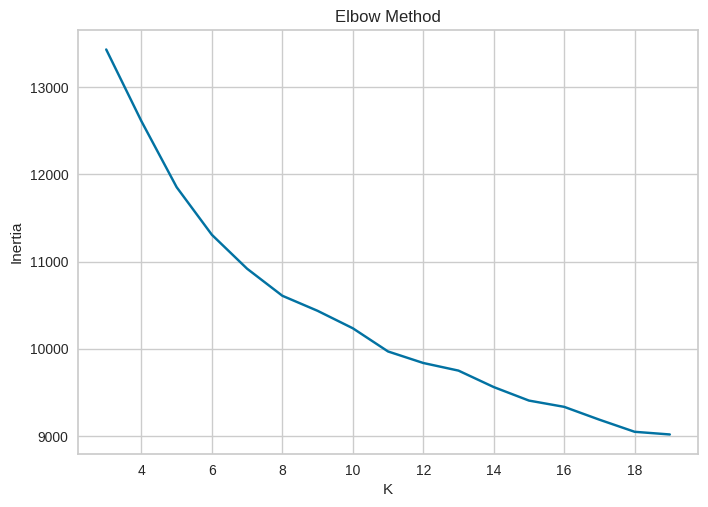

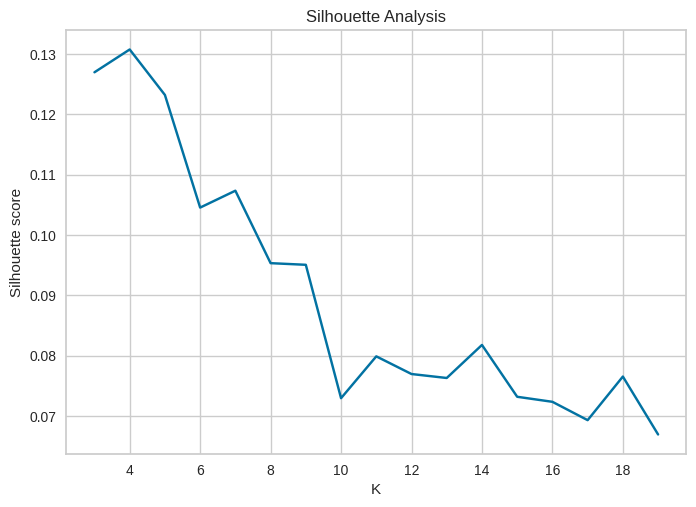

In [ ]:
# Elbow Method and Silhoutte Score Plot for the full-dimensiona;/original dataset
# to find the optimal number of clusters (k), the elbow method is used and the silhoutte score for each is compared
silhouette = [] # for the silhoutte score
inertia = [] # list of squares um of the distances of a point from the centroid
k = range(3,20) # clusters values from 4-20 are checked
# for each number of cluster, k-means is run and and inertia is calculated
# low inertia is preferred
for ks in k :
  kmeans = KMeans(n_clusters=ks, n_init=10, random_state=0)
  kmeans.fit(data)
  inertia.append(kmeans.inertia_)
  silhouette.append(silhouette_score(data, kmeans.labels_))

# to check for the point where the inertia is low and the number of clusters are balanced (elbow point)
plt.plot(k,inertia)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# to check for k with highest silhoutte score
plt.plot(k, silhouette)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.show()

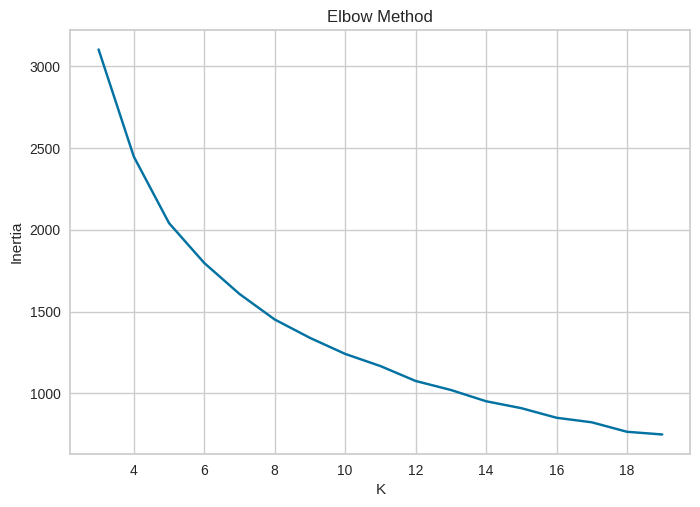

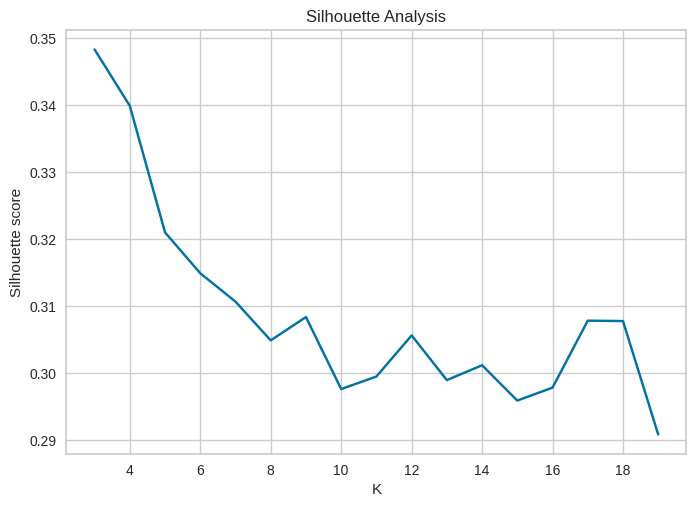

In [ ]:
# Elbow Method and Silhoutte Score Plot for the reduced dataset
# to find the optimal number of clusters (k), the elbow method is used and the silhoutte score for each is compared
silhouette = [] # for the silhoutte score
inertia = [] # list of squares um of the distances of a point from the centroid
k = range(3,20) # clusters values from 4-20 are checked
# for each number of cluster, k-means is run and and inertia is calculated
# low inertia is preferred
for ks in k :
  kmeans = KMeans(n_clusters=ks, n_init=10, random_state=0)
  kmeans.fit(reduced_data)
  inertia.append(kmeans.inertia_)
  silhouette.append(silhouette_score(reduced_data, kmeans.labels_))

# to check for the point where the inertia is low and the number of clusters are balanced (elbow point)
plt.plot(k,inertia)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# to check for k with highest silhoutte score
plt.plot(k, silhouette)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.show()

# optimal k value from both the analysis is decided to be 3.

Silhouette coefficient: 0.13075723506451634
outliers in cluster 0 : []
outliers in cluster 1 : [369]
outliers in cluster 2 : [95]
outliers in cluster 3 : [97]


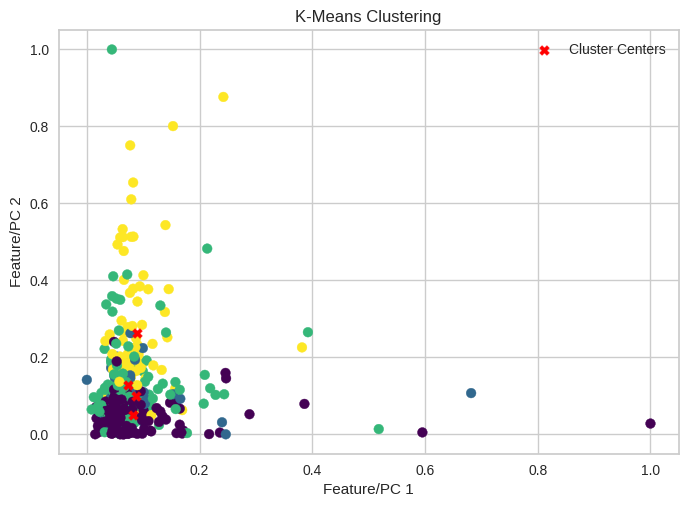

Silhouette coefficient: 0.34829723100083054
outliers in cluster 0 : []
outliers in cluster 1 : [369]
outliers in cluster 2 : []


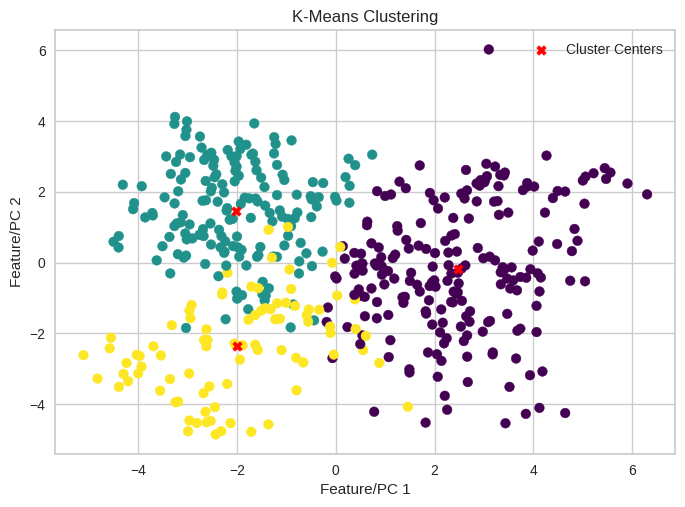

Adjusted Rand Score: 0.7247886502859638


In [ ]:
# Running k-means clusering on the dataset with a randomly assigned initial number of clusters
k1 = 4 # number of clusters
kmeans1 = KMeans(n_clusters=k1, random_state=0, n_init=10)
kmeans1.fit(data) # fitting a k-means model; running the algorithm on this data.
clusters_original = kmeans1.labels_ # clusters assgined to the data points

k2 = 3 # number of clusters
kmeans2 = KMeans(n_clusters=k2, random_state=0, n_init=10)
clusters_reduced = kmeans2.fit_predict(reduced_data) # the new clusters lables assigned

testingfunc(data, clusters_original, kmeans1.cluster_centers_, k1)
testingfunc(reduced_data, clusters_reduced, kmeans2.cluster_centers_, k2)
ars = adjusted_rand_score(clusters_original, clusters_reduced) # comparing the two clusterings
print("Adjusted Rand Score:", ars)

#### Grid Search

In [ ]:
# parameter grid/dictionary to test for the K-means model
param_grid = {
    'n_clusters': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 300, 500],
}

kmeans = KMeans(n_init=10) # k-means model
grid_search_km = GridSearchCV(estimator=kmeans, param_grid=param_grid) # to search for the optimal parameter values for k-means
grid_search_km.fit(data) # fitting the model on the original data
print("Best parameters for K-means:", grid_search_km.best_params_)

grid_search_km.fit(reduced_data) # fitting the model on the reduced data
print("Best parameters for K-means:", grid_search_km.best_params_)

Best parameters for K-means: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 15}
Best parameters for K-means: {'init': 'k-means++', 'max_iter': 500, 'n_clusters': 15}


Silhouette coefficient: 0.07320157433088648
outliers in cluster 0 : []
outliers in cluster 1 : []
outliers in cluster 2 : []
outliers in cluster 3 : []
outliers in cluster 4 : []
outliers in cluster 5 : []
outliers in cluster 6 : []
outliers in cluster 7 : []
outliers in cluster 8 : [369]
outliers in cluster 9 : []
outliers in cluster 10 : []
outliers in cluster 11 : []
outliers in cluster 12 : []
outliers in cluster 13 : [95 97]
outliers in cluster 14 : []


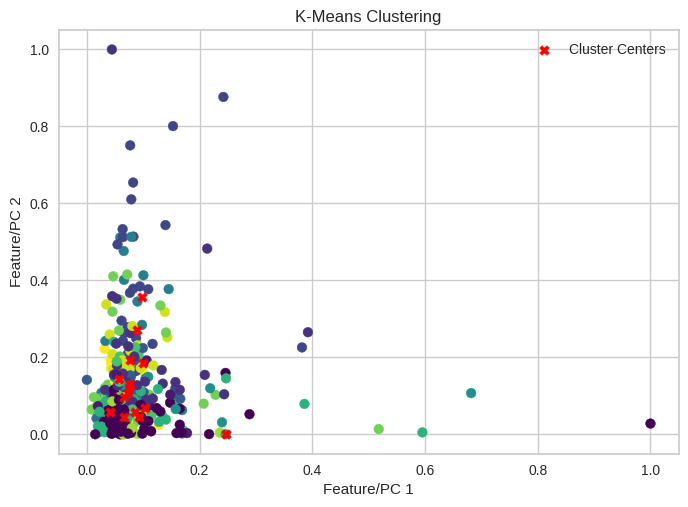

Silhouette coefficient: 0.29595091059227674
outliers in cluster 0 : []
outliers in cluster 1 : []
outliers in cluster 2 : []
outliers in cluster 3 : []
outliers in cluster 4 : []
outliers in cluster 5 : []
outliers in cluster 6 : []
outliers in cluster 7 : []
outliers in cluster 8 : [369]
outliers in cluster 9 : []
outliers in cluster 10 : []
outliers in cluster 11 : []
outliers in cluster 12 : []
outliers in cluster 13 : []
outliers in cluster 14 : []


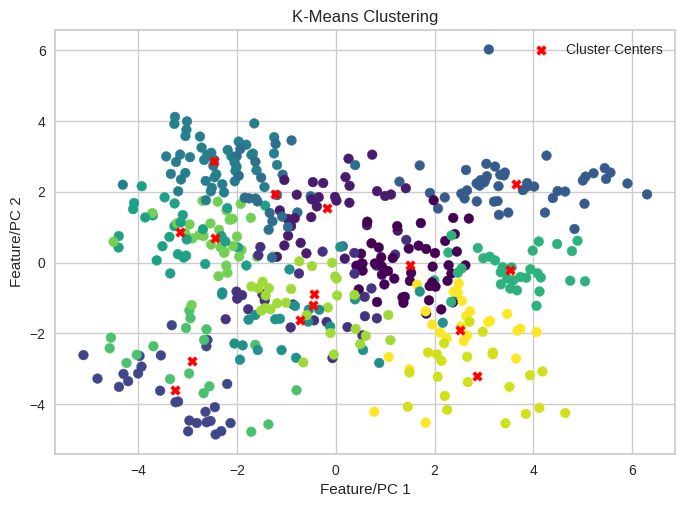

Adjusted Rand Score: 0.454175550490149


In [ ]:
# Running k-means clusering on the dataset with a randomly assigned initial number of clusters
k1 = 15 # number of clusters
kmeans1 = KMeans(init= 'k-means++', max_iter= 300, n_clusters=k1, random_state=0, n_init=10)
kmeans1.fit(data) # fitting a k-means model; running the algorithm on this data.
clusters_original = kmeans1.labels_ # clusters assgined to the data points

k2 = 15 # number of clusters
kmeans2 = KMeans(init= 'k-means++', max_iter= 500, n_clusters=k2, random_state=0, n_init=10)
clusters_reduced = kmeans2.fit_predict(reduced_data) # the new clusters lables assigned

testingfunc(data, clusters_original, kmeans1.cluster_centers_, k1)
testingfunc(reduced_data, clusters_reduced, kmeans2.cluster_centers_, k2)
ars = adjusted_rand_score(clusters_original, clusters_reduced) # comparing the two clusterings
print("Adjusted Rand Score:", ars)

#### Using clusteval library

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:   4%|▍         | 1/23 [00:00<00:20,  1.10it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:   9%|▊         | 2/23 [00:01<00:20,  1.04it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

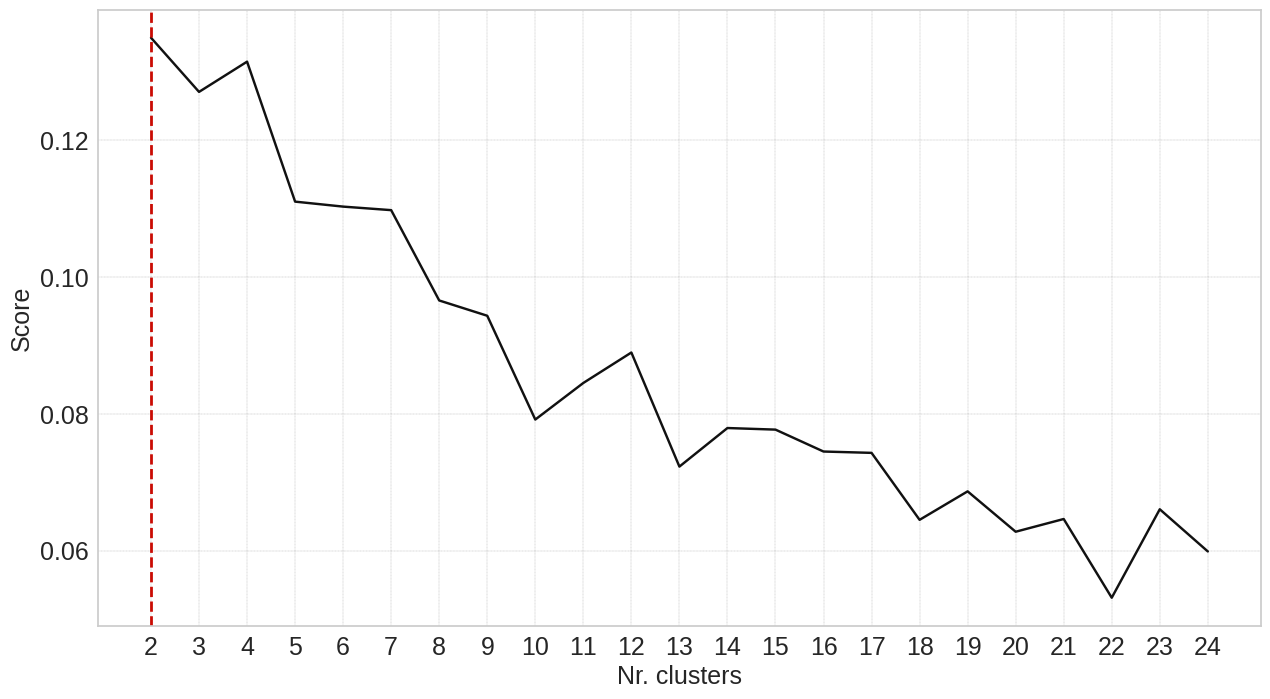

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:   9%|▊         | 2/23 [00:00<00:01, 11.86it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/

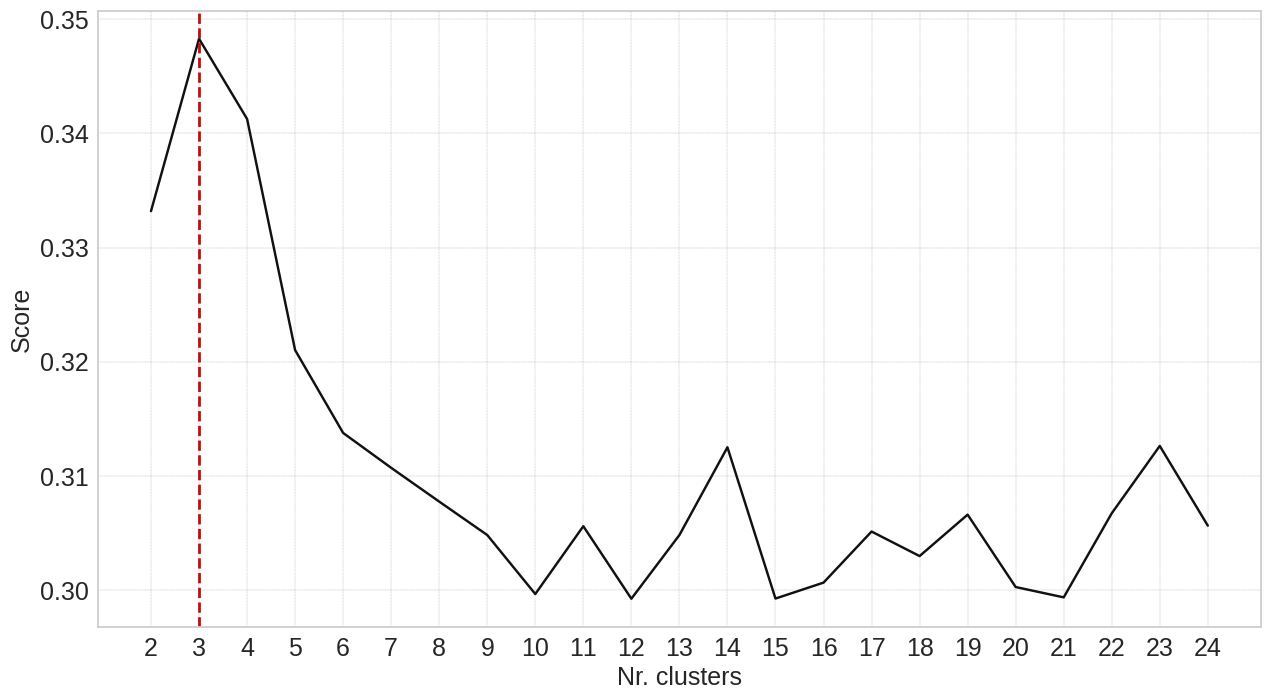

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [ ]:
ceval = clusteval('kmeans') # to evaluate kmeans model
results= ceval.fit(data) # to find optimal k for the original data
ceval.plot() # plot of silhoutte score with k value highlighted

results= ceval.fit(reduced_data) # to find optimal k for the original data
ceval.plot() # plot of silhoutte score with k value highlighted

Silhouette coefficient: 0.13477759073738238
outliers in cluster 0 : [ 95  97 369]
outliers in cluster 1 : []


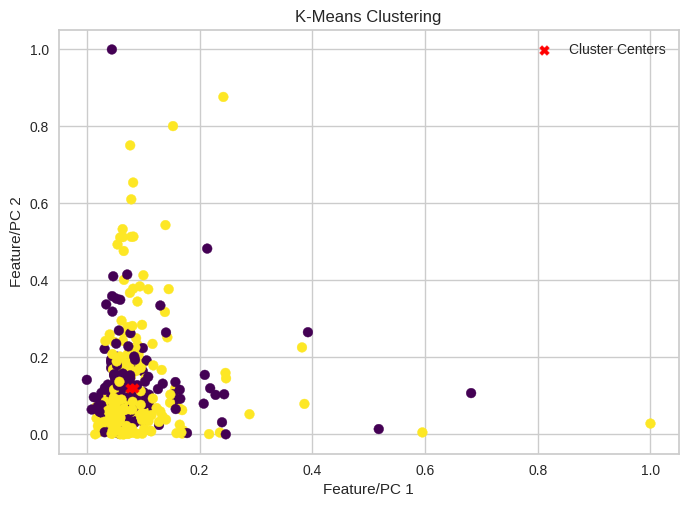

Silhouette coefficient: 0.34829723100083054
outliers in cluster 0 : [369]
outliers in cluster 1 : []
outliers in cluster 2 : []


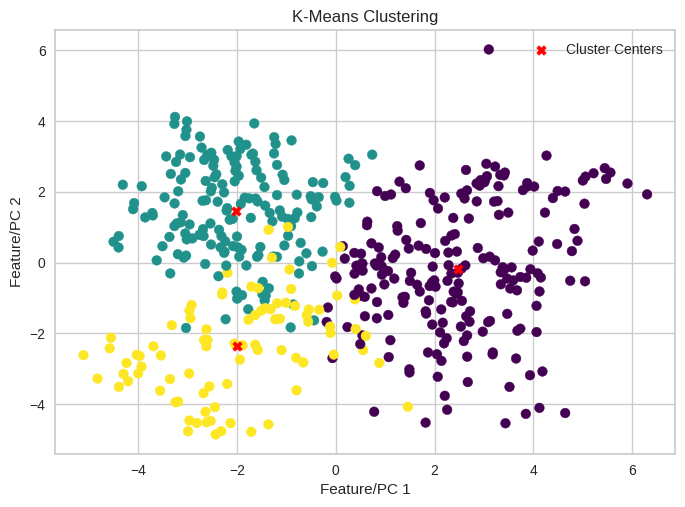

Adjusted Rand Score: 0.6672002911708571


In [ ]:
# Running k-means clusering on the dataset with a randomly assigned initial number of clusters
k1 = 2 # number of clusters
kmeans1 = KMeans(n_clusters=k1, random_state=0, n_init=1)
kmeans1.fit(data) # fitting a k-means model; running the algorithm on this data.
clusters_original = kmeans1.labels_ # clusters assgined to the data points

k2 = 3 # number of clusters
kmeans2 = KMeans(n_clusters=k2, random_state=0, n_init=1)
clusters_reduced = kmeans2.fit_predict(reduced_data) # the new clusters lables assigned

testingfunc(data, clusters_original, kmeans1.cluster_centers_, k1)
testingfunc(reduced_data, clusters_reduced, kmeans2.cluster_centers_, k2)
ars = adjusted_rand_score(clusters_original, clusters_reduced) # comparing the two clusterings
print("Adjusted Rand Score:", ars)

### Ideal Run

In [ ]:
# Running k-means clusering on the dataset with a randomly assigned initial number of clusters
k1 = 3 # number of clusters
kmeans1 = KMeans(n_clusters=k1, random_state=0, n_init=10)
kmeans1.fit(data) # fitting a k-means model; running the algorithm on this data.
clusters_original = kmeans1.labels_ # clusters assgined to the data points
print("Unique clusters:\n",np.unique(clusters_original))
print("Cluster counts:\n",pd.Series(clusters_original).value_counts())

n = data.shape[0] # number of rows/observations
M = np.zeros((n, n)) # M matrix with all 0s

# to populate M with 1 if observations at i and j are in the same cluster and 0 is left if they are in different clusters
for i in range(n):
    for j in range(n):
        if clusters_original[i] == clusters_original[j]:
            M[i][j] = 1


k2 = 3 # number of clusters
kmeans2 = KMeans(n_clusters=k2, random_state=0, n_init=10)
clusters_reduced = kmeans2.fit_predict(reduced_data) # the new clusters lables assigned
print("Unique clusters:\n",np.unique(clusters_original))
print("New cluster counts:\n",pd.Series(clusters_reduced).value_counts())

P = np.zeros((n, n))
# to populate P with 1 if observations at i and j are in the same cluster and 0 is left if they are in different clusters
for i in range(n):
    for j in range(n):
        if clusters_reduced[i] == clusters_reduced[j]:
            P[i][j] = 1

# checking the number of matching cluster assignments from M and P
matches = np.sum(M == P)
print("Number of matching cluster assignments between M and P:", matches)
print("Percentage of matching cluster assignments = ", round(matches/(n*n) * 100,2))

Unique clusters:
 [0 1 2]
Cluster counts:
 2    204
0    168
1     87
dtype: int64
Unique clusters:
 [0 1 2]
New cluster counts:
 0    206
1    166
2     87
dtype: int64
Number of matching cluster assignments between M and P: 204145
Percentage of matching cluster assignments =  96.9


Silhouette coefficient: 0.12697772248801314
outliers in cluster 0 : []
outliers in cluster 1 : [97]
outliers in cluster 2 : [ 95 369]


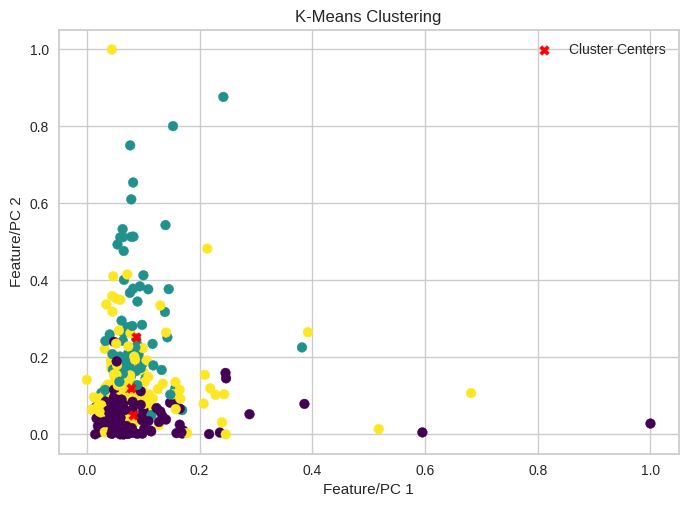

Silhouette coefficient: 0.34829723100083054
outliers in cluster 0 : []
outliers in cluster 1 : []
outliers in cluster 2 : [369]


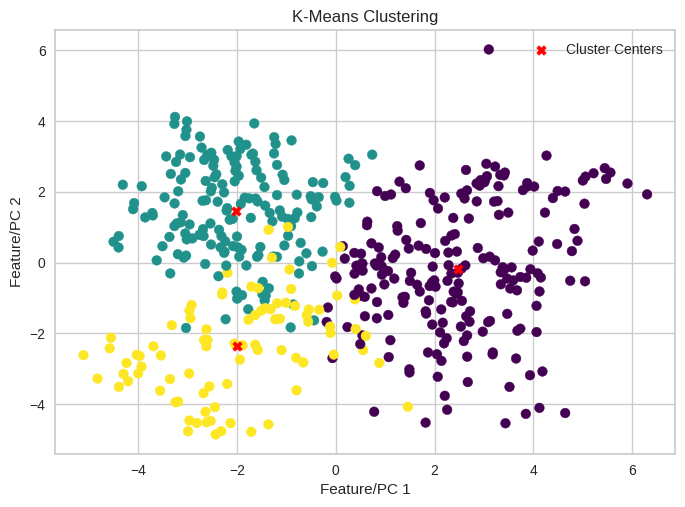

Adjusted Rand Score: 0.9330375340064555


In [ ]:
testingfunc(data, clusters_original, kmeans1.cluster_centers_, k1)
testingfunc(reduced_data, clusters_reduced, kmeans2.cluster_centers_, k2)
ars = adjusted_rand_score(clusters_original, clusters_reduced) # comparing the two clusterings
print("Adjusted Rand Score:", ars)

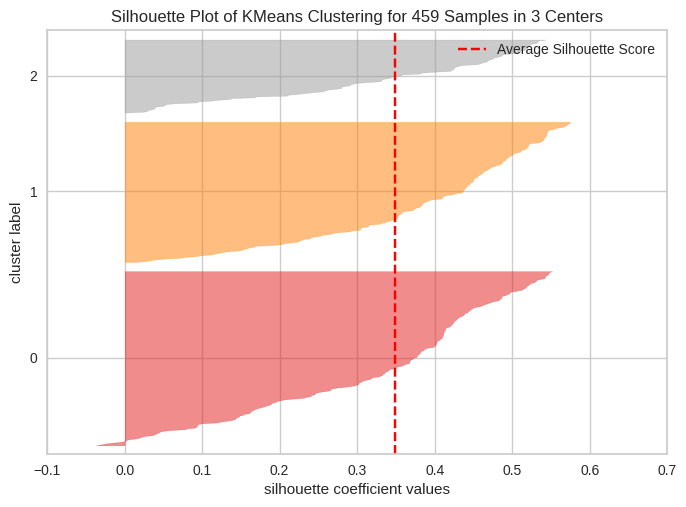

In [ ]:
# to visualize the average silhoutte score for the kmeans model instantiated using yellowbrick
visualizer = SilhouetteVisualizer(kmeans2)
visualizer.fit(reduced_data)
visualizer.show()
plt.show()

Text(0.5, 0, 'Principal Component 3')

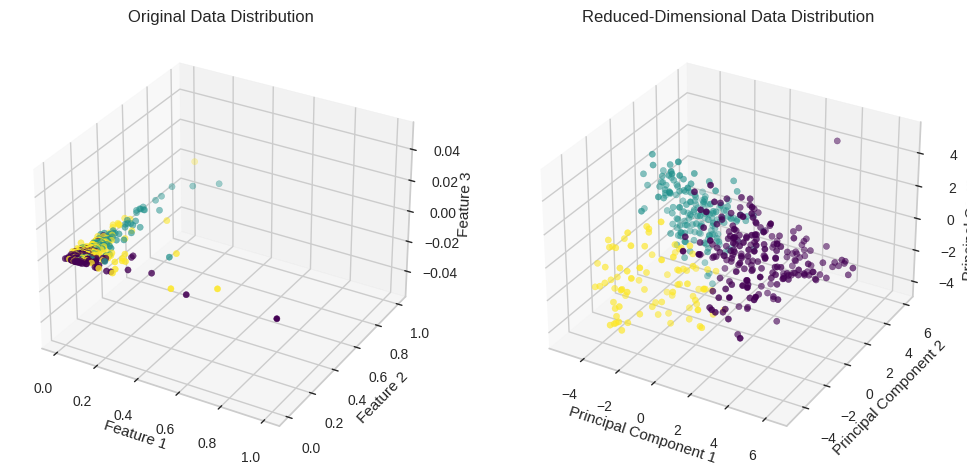

In [ ]:
# 3D plots
fig = plt.figure(figsize=(12, 6))
# plotting the data points for the first 3 features
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], c=clusters_original, cmap='viridis')
ax1.set_title("Original Data Distribution")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Feature 3")

# plotting the data points in the reduced dataset for the first 3 principal compenents
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(reduced_data.iloc[:, 0], reduced_data.iloc[:, 1], reduced_data.iloc[:, 2], c=clusters_reduced, cmap='viridis')
ax2.set_title("Reduced-Dimensional Data Distribution")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Component 3")

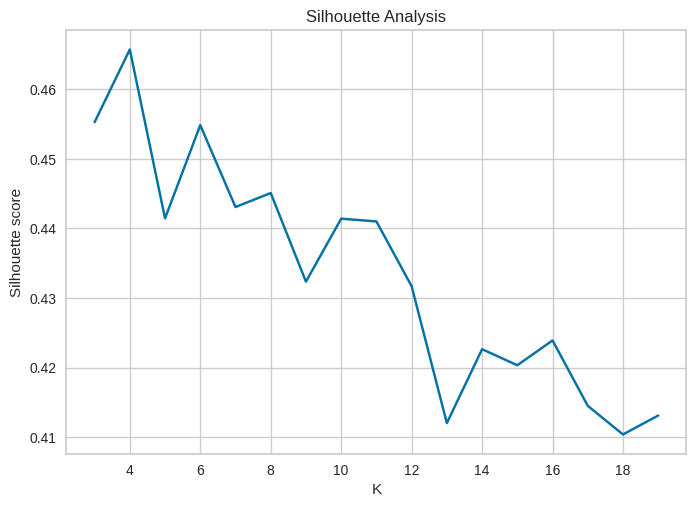

In [ ]:
# Elbow Method and Silhoutte Score Plot
# to find the optimal number of clusters (k), the elbow method is used and the silhoutte score for each is compared
silhouette = [] # for the silhoutte score
k = range(3,20) # clusters values from 4-20 are checked
# for each number of cluster, k-means is run and and inertia is calculated
# low inertia is preferred
for ks in k :
  kmeans = KMeans(n_clusters=ks, n_init=10, random_state=0)
  kmeans.fit(tsne)
  silhouette.append(silhouette_score(tsne, kmeans.labels_))

# to check for k with highest silhoutte score
plt.plot(k, silhouette)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.show()

Silhouette score:  0.45528308


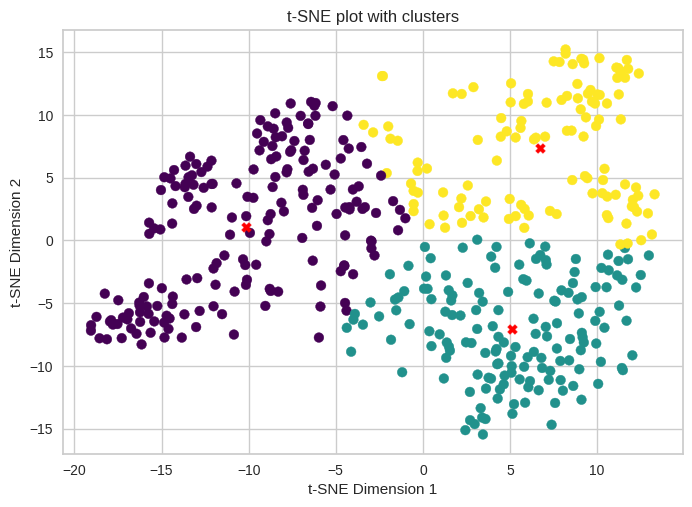

In [ ]:
k = 3 # number of clusters
# K-means clustering on the t-sne-reuced data
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
clusters = kmeans.fit_predict(tsne) # clusters predcicted for the data
silhouette_tsne = silhouette_score(tsne, clusters) # silhoutte score of tsne reduced data
print("Silhouette score: ", silhouette_tsne)

# Clustering visualization on t-SNE-reduced data
plt.scatter(tsne.iloc[:, 0], tsne.iloc[:, 1], c=clusters, cmap='viridis') # both the tsne dimensions
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', label='Cluster Centers') # for the cluster centres
plt.title('t-SNE plot with clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
T = np.zeros((n, n))
# to populate P with 1 if observations at i and j are in the same cluster and 0 is left if they are in different clusters
for i in range(n):
    for j in range(n):
        if clusters[i] == clusters[j]:
            T[i][j] = 1

# checking the number of matching cluster assignments from M and T
matches = np.sum(M == T)
print("Number of matching cluster assignments between M and T:", matches)
print("Percentage of matching cluster assignments = ", round(matches/(n*n) * 100,2))

Number of matching cluster assignments between M and T: 184499
Percentage of matching cluster assignments =  87.57


In [ ]:
k = 4 # number of clusters
# K-means clustering on the t-sne-reuced data
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
clusters = kmeans.fit_predict(tsne) # clusters predcicted for the data
silhouette_tsne = silhouette_score(tsne, clusters) # silhoutte score of tsne reduced data
print("\n\nSilhouette score: ", silhouette_tsne)



Silhouette score:  0.46575257


Silhouette coefficient: 0.46575257
outliers in cluster 0 : []
outliers in cluster 1 : []
outliers in cluster 2 : []
outliers in cluster 3 : []


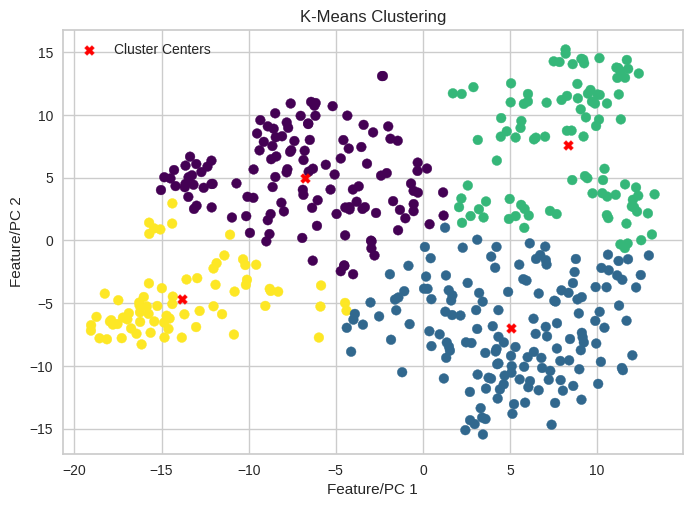

Adjusted Rand Score: 0.2885233214123719


In [ ]:
testingfunc(tsne, clusters, kmeans.cluster_centers_, k)
ars = adjusted_rand_score(clusters_original, clusters) # comparing the two clusterings
print("Adjusted Rand Score:", ars)

### Impact of Initialization on K-Means Clustering

In [ ]:
# some initializations/assignments are repeated in every section for better clarity in understanding the values
k = 3 # number of clusters
M_list = [] # to store matrices M1-M10
n = data.shape[0] # number of observations
randoms = [random.randint(1, 50) for _ in range(10)] # random initializations

# performing k-means clustering on the original dataset ten times with different initializations
for i in randoms:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=i, init='random') # k-means run with different random initial states
    kmeans.fit(data)
    clusters = kmeans.labels_

    # matrix M for this run is created as described in the previous section
    M = np.zeros((n,n))
    for i in range(n):
      for j in range(n):
        M[i,j] = 1 if clusters[i] == clusters[j] else 0

    M_list.append(M) # storing each of the M matrices made in each of the iterations

In [ ]:
# if pairs of observations are in the same cluster in at least one run or not
# element-wise logical OR is done by rows
Mi = np.logical_or.reduce(M_list)

# if pairs of observations are in the same cluster in all ten runs or not
M_all = np.logical_and.reduce(M_list)

# percentage of pairs in the same cluster in all ten runs
percentage = (np.sum(M_all) / np.sum(Mi)) * 100

print("The percentage of pairs in the same cluster in all ten runs= ", percentage, "%")

The percentage of pairs in the same cluster in all ten runs=  90.81596436045871 %


In [ ]:
k = 3 # number of clusters
M_list = [] # to store matrices M1-M10
n = data.shape[0] # number of observations
randoms = [random.randint(1, 50) for _ in range(10)] # random initializations

# performing k-means clustering on the original dataset ten times with different initializations
for i in randoms:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=i, init='random') # k-means run with different random initial states
    kmeans.fit(reduced_data)
    clusters = kmeans.labels_

    # matrix M for this run is created as described in the previous section
    M = np.zeros((n,n))
    for i in range(n):
      for j in range(n):
        M[i,j] = 1 if clusters[i] == clusters[j] else 0

    M_list.append(M) # storing each of the M matrices made in each of the iterations

# if pairs of observations are in the same cluster in at least one run or not
# element-wise logical OR is done by rows
Mi = np.logical_or.reduce(M_list)

# if pairs of observations are in the same cluster in all ten runs or not
M_all = np.logical_and.reduce(M_list)

# percentage of pairs in the same cluster in all ten runs
percentage = (np.sum(M_all) / np.sum(Mi)) * 100

print("The percentage of pairs in the same cluster in all ten runs= ", percentage, "%")

The percentage of pairs in the same cluster in all ten runs=  97.66352157093064 %


## Single-Linkage Clustering

Dimensions of linkage matrix:  (458, 4)
The number of entries S has in common with P: 77755

Percentage of matching cluster assignments =  36.91
Silhouette coefficient: 0.1923758463015274


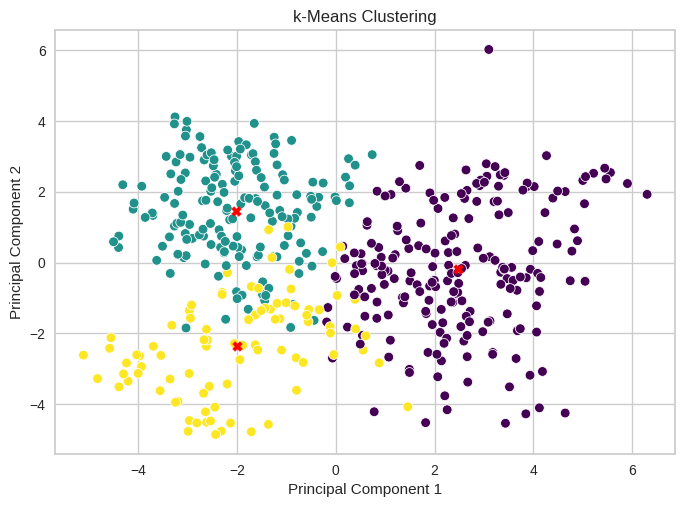

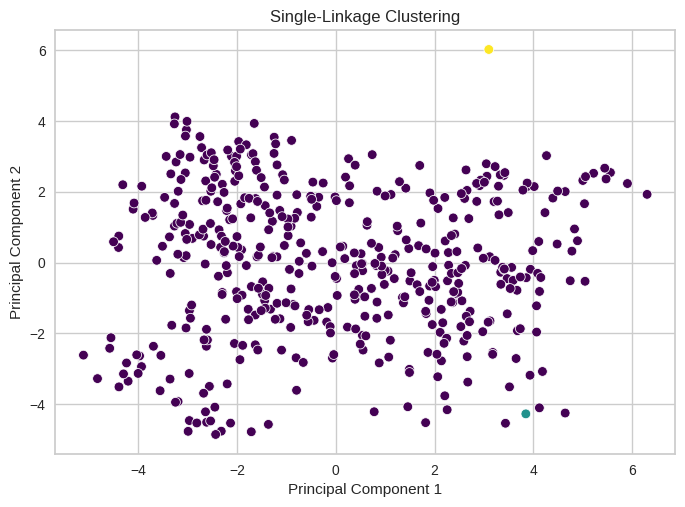

In [ ]:
k = 3 # number of clusters
# linkage matrix describes the hierarchical relationships between the data samples
linked = linkage(reduced_data, method='single') # single-linkage clustering on the reduced-dimensionality dataset
# returns an array of cluster labels for the observations
single_linkage_labels = fcluster(linked, k, criterion='maxclust') # use the maximum number of clusters specified by k

# matrix for the single-linkage clustering result
n = reduced_data.shape[0]
S = np.zeros((n, n))
for i in range(n):
  for j in range(n):
    if single_linkage_labels[i] == single_linkage_labels[j]:
      S[i,j] = 1

# Compare entries of S with P
matches = np.sum(S == P)
print("Dimensions of linkage matrix: ", linked.shape)
print("The number of entries S has in common with P:", matches)
print("\nPercentage of matching cluster assignments = ", round(matches/(n*n) * 100,2))

# silhoutte score of the single linkage clustering on the reduced-dimensionality dataset
silhouette_reduced_linkage = silhouette_score(reduced_data, single_linkage_labels)
print("Silhouette coefficient:", silhouette_reduced_linkage)

# Scatterplots with the first two prinicpal components on the axes
# for k-means clustering
sns.scatterplot(x=reduced_data.iloc[:, 0], y=reduced_data.iloc[:, 1], c=clusters_reduced, cmap='viridis')
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], c='red', marker='X', label='Cluster Centers') # for the cluster centres
plt.title('k-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# for single-linkage clustering
sns.scatterplot(x=reduced_data.iloc[:, 0], y=reduced_data.iloc[:, 1], c=single_linkage_labels, cmap='viridis')
plt.title('Single-Linkage Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
def single_silhouette(data1):
  '''
    For the Silhoutte Score Plot to find optimal k
  '''
  # to find the optimal number of clusters (k), the silhoutte score for each is compared
  silhouette = [] # for the silhoutte score
  k = range(3,20) # clusters values from 4-20 are checked
  # for each number of cluster, single linkage clustering is run and and the score is calculated
  for ks in k :
    linked = linkage(data1, method='single') # single-linkage clustering on the reduced-dimensionality dataset
    single_linkage_labels = fcluster(linked, ks, criterion='maxclust') # use the maximum number of clusters specified by k
    silhouette.append(silhouette_score(data1, single_linkage_labels))

  # to check for k with highest silhoutte score
  plt.plot(k, silhouette)
  plt.xlabel('K')
  plt.ylabel('Silhouette score')
  plt.title('Silhouette Analysis')
  plt.grid(True)
  plt.show()

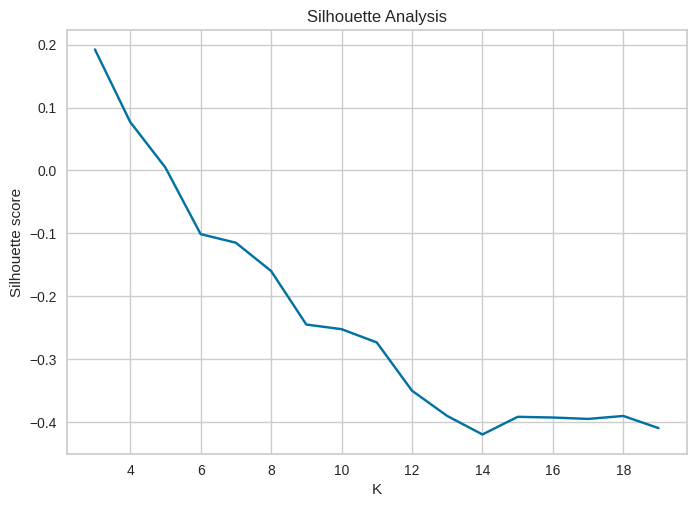

In [ ]:
single_silhouette(reduced_data)

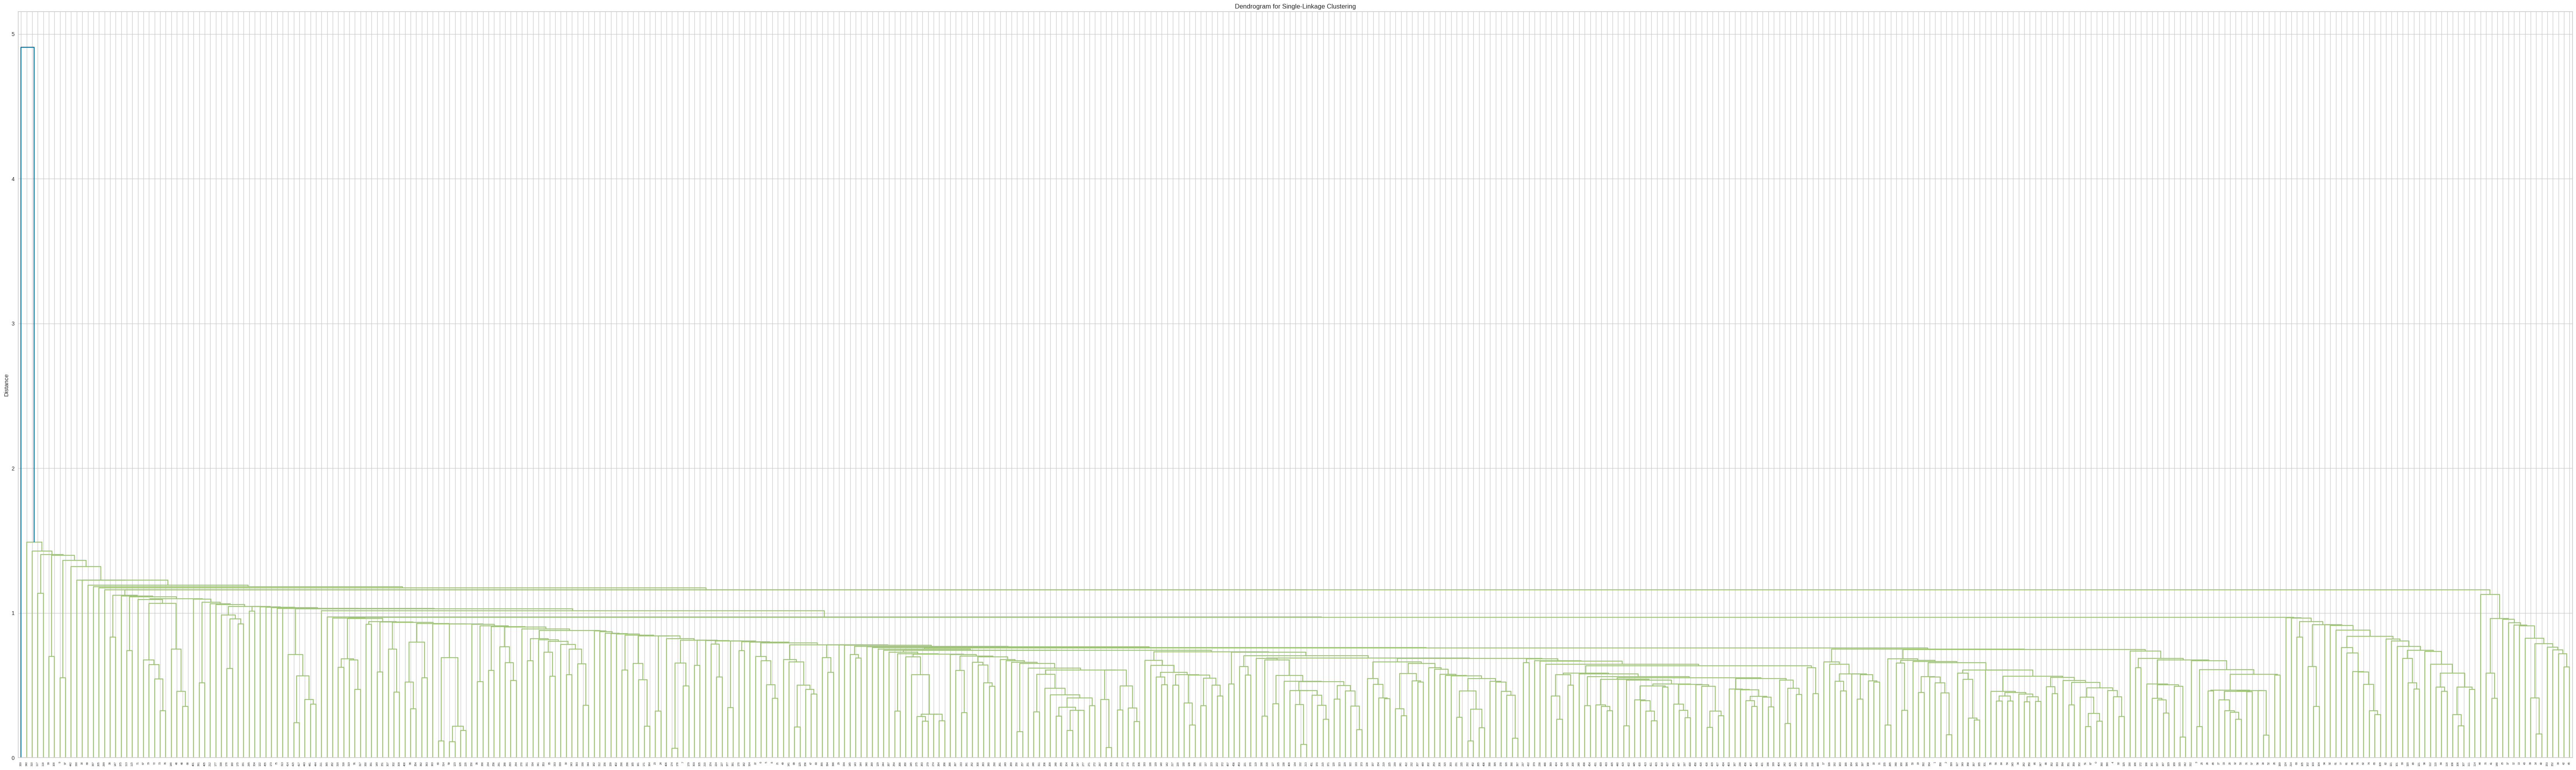

In [ ]:
# Dendrogram for single-linkage clustering as its a hierarchial clustering algorithm
plt.figure(figsize=(85,25))
dendrogram(Z=linked)
plt.title('Dendrogram for Single-Linkage Clustering')
plt.ylabel('Distance')
plt.show()

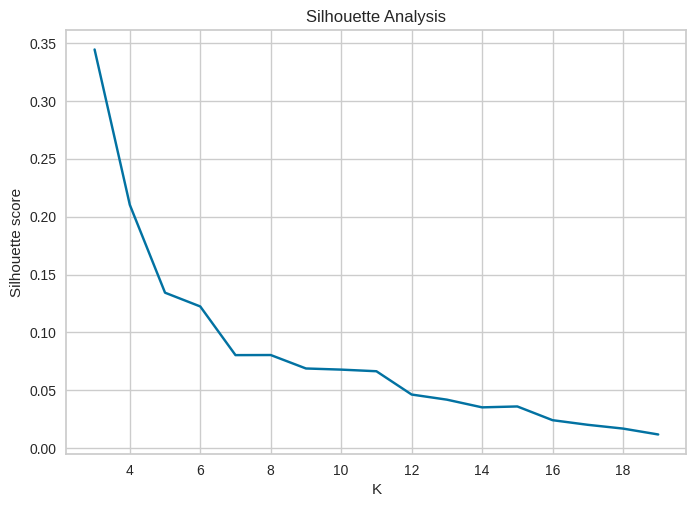

In [ ]:
single_silhouette(data)

In [ ]:
k = 3
# linkage matrix describes the hierarchical relationships between the data samples
linked = linkage(data, method='single') # single-linkage clustering on the dataset
# returns an array of cluster labels for the observations
single_linkage_labels1 = fcluster(linked, k, criterion='maxclust') # use the maximum number of clusters specified by k

# silhoutte score of the single linkage clustering on the dataset
silhouette_linkage1 = silhouette_score(data, single_linkage_labels1)
print("Silhouette coefficient:", silhouette_linkage1)

Silhouette coefficient: 0.3446110238026117


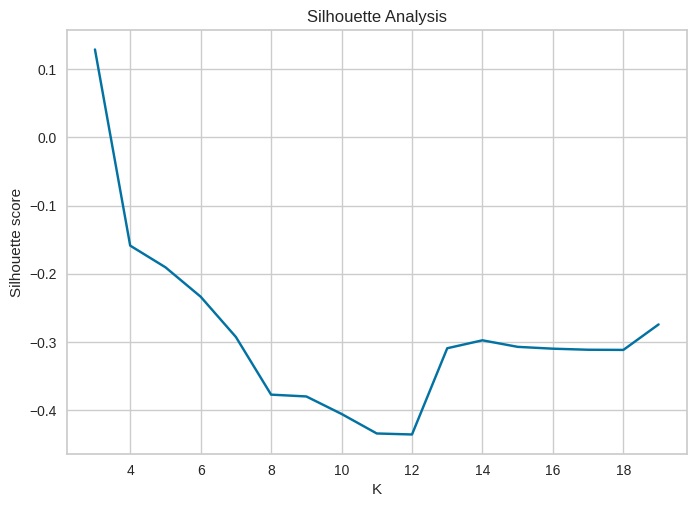

In [ ]:
single_silhouette(tsne) # for tsne data

In [ ]:
# linkage matrix describes the hierarchical relationships between the data samples
k = 3
linked = linkage(tsne, method='single') # single-linkage clustering on the reduced-dimensionality dataset
# returns an array of cluster labels for the observations
single_linkage_labels2 = fcluster(linked, k, criterion='maxclust') # use the maximum number of clusters specified by k

# silhoutte score of the single linkage clustering on the reduced-dimensionality dataset
silhouette_reduced_linkage2 = silhouette_score(tsne, single_linkage_labels2)
print("Silhouette coefficient:", silhouette_reduced_linkage2)

Silhouette coefficient: 0.12883712


## GMM + Expectation-Maximization Algorithm

In [ ]:
def gmm(data1, k):
  '''
    To perform expectation-maximization algorithm with k clusters on reduced-dimensional data
    and return the proababilities and labels
  '''
  model = GaussianMixture(n_components=k, init_params='k-means++', covariance_type="full") # instantiating a GMM with the given parameters
  model.fit(data1) # fitting the model on the data reduced by PCA

  # Probabilistic assignment of observations to clusters
  # components' density for each sample in the dataset
  probs = model.predict_proba(data1)
  # cluster centres generated
  gmm_labels = model.predict(data1)

  # printing the AIC and BIC scores
  print("AIC Score:", model.aic(data1))
  print("BIC Score:", model.bic(data1))
  print("Silhouette coefficient:", silhouette_score(data1, gmm_labels))


  # ----------------------------------------------------------------------------
  # for confidence ellipses- following code modified from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
  colors = sns.color_palette("bright", k) # to set the colors for plotting
  fig, ax = plt.subplots() # figure and axis for plotting

  # iterating over the means, covariances, and colors to create ellipses
  # based on the mean and covariance of differenr colors around the clusters
  for i, (mean, cov, color) in enumerate(zip(model.means_, model.covariances_, colors)):

      eig_vals, eig_vector = linalg.eigh(cov) # eigenvalues and eigenvectors of the covariance matrix

      # to check if any data points belong to the current component/cluster
      if not np.any(gmm_labels == i):
          continue

      # scatterplot of the data points belonging to the current component/cluster
      ax.scatter(data1.iloc[gmm_labels == i, 0], data1.iloc[gmm_labels == i, 1], s=0.8, color=color)

      angle = np.arctan2(eig_vector[0][1], eig_vector[0][0]) # represents the angle of rotation for the ellipse
      angle = 180.0 * angle / np.pi  # converting the angle from radians to degrees
      v = 2.0 * np.sqrt(2.0) * np.sqrt(eig_vals) # lengths of the major and minor axes of the ellipse

      # Ellipse object with the parameters calculated for the cluster
      ellipse = Ellipse(mean, eig_vals[0], eig_vals[1], angle=180.0 + angle, color=color, alpha=0.5)
      ax.add_artist(ellipse) # the ellipse is added to the plot

  ax.set_title(f"GMM with {k} number of components")
  plt.show()

  return probs, gmm_labels

AIC Score: 5755.044550099038
BIC Score: 5874.787006190794
Silhouette coefficient: 0.33539647346015694


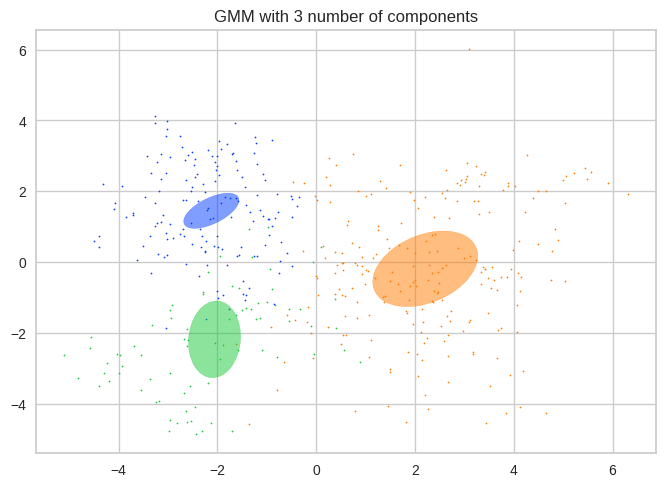



Percentage of observations with at least two different clusters: 41.18%


In [ ]:
# GMM on the data reduced by PCA
# Default covariance type where each component has its own general covariance matrix.
probs, gmm_labels = gmm(reduced_data,3)
n = len(reduced_data) # number of observations
E = np.zeros((n,n)) # instantiating matrix-E of size nxn

# to loop over each pairs of observations
for i in range(n):
    for j in range(n):
      # element-wise multiplication of the probability vectors
      # of observations i and j are summed
       E[i, j] = np.sum(probs[i] * probs[j])

# to ensure entries of E are between 0 and 1
E = np.clip(E, 0, 1)

#-------------------------------------------------------------------------------
# represents number of observations with at least two different clusters
count = 0

for i in range(n):
    # indices of clusters with probability > 1% for an observation
    clusters_above_threshold = np.where(probs[i] > 0.01)[0]

    # to check if there are at least two different clusters
    if len(set(clusters_above_threshold)) >= 2:
        count += 1

print(f"\n\nPercentage of observations with at least two different clusters: {((count/n)*100):.2f}%")

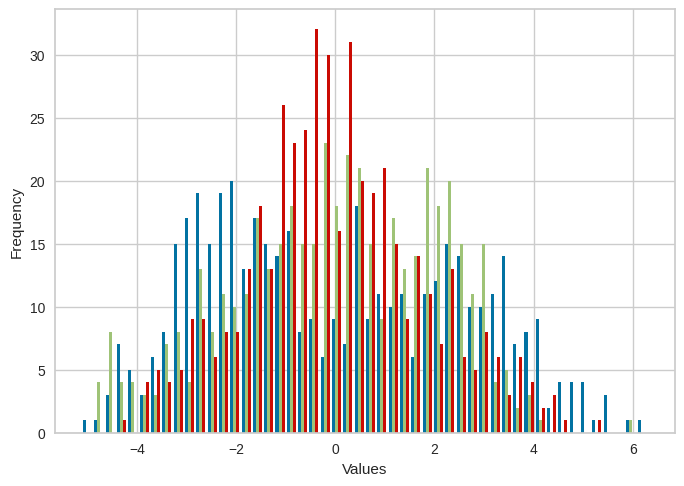

In [ ]:
# Histogram to show the bell-shaped distribution of the data
plt.hist(reduced_data, bins=50)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# inspired from- https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#:~:text=In%20this%20case%2C%20both%20the,among%20a%20set%20of%20candidates.

def gmm_bic_score(estimator, X):
  '''
    For GridSearchCV; to use BIC to select parameters
  '''
  return -estimator.bic(X) # negative as GridSearchCV expects a score to maximize

def bic_grid_search(data1):
  '''
    To try Grid Search over the parameters using BIC score
    lower the BIC, the better
  '''
  parameters = {'n_components': [3,4,5,6,7,8,9,10,11]} # parameter to search for
  gscv = GridSearchCV(GaussianMixture(init_params='k-means++'), parameters, scoring=gmm_bic_score) # to search over the parameter for the GMM
  gscv.fit(data1) # to fit the model on the PCA-reduced dataset
  test_score = - (gscv.cv_results_['mean_test_score'])

  sns.barplot(x=gscv.cv_results_['param_n_components'], y=test_score) #optional hue=gscv.cv_results_['param_covariance_type']
  plt.xlabel('Number of Components')
  plt.ylabel('BIC Score')
  plt.show()

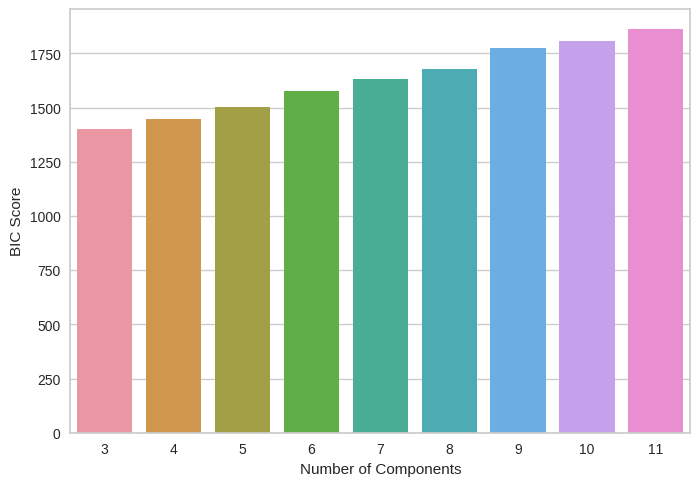

In [ ]:
bic_grid_search(reduced_data)

AIC Score: 5795.055615292675
BIC Score: 5914.798071384431
Silhouette coefficient: 0.28706997624350755


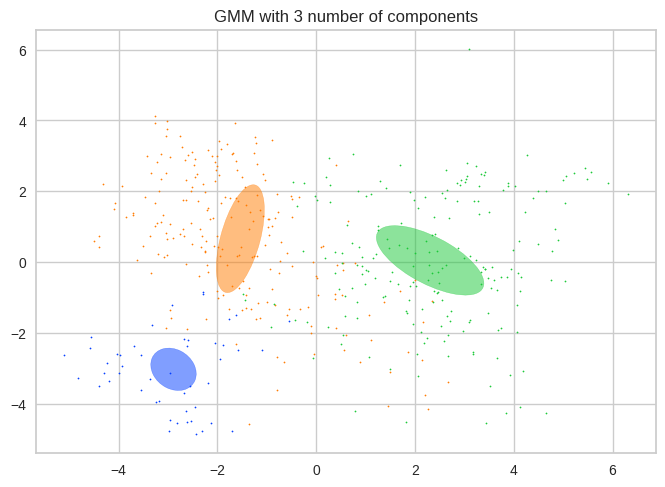

Unique clusters:  [0 1 2]


In [ ]:
probs, gmm_labels = gmm(reduced_data, 3) # GMM on PCA-reduced data with optimal values, only tied and full work
print("Unique clusters: ", np.unique(gmm_labels))

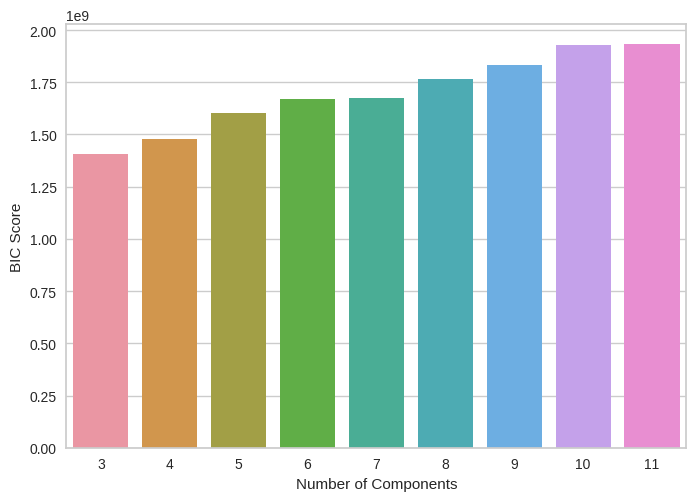

In [ ]:
bic_grid_search(data)

AIC Score: 3418814.421721885
BIC Score: 33627800.471918315
Silhouette coefficient: 0.08970956586863009


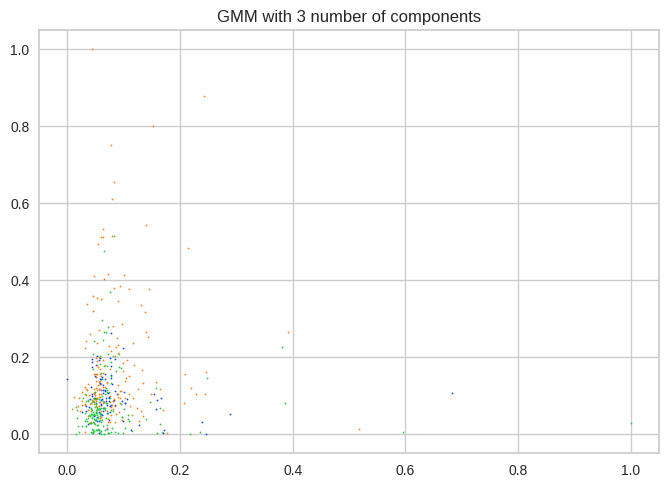

Unique clusters:  [0 1 2]


In [ ]:
probs, gmm_labels = gmm(data, 3) # GMM on the original data with optimal values
print("Unique clusters: ", np.unique(gmm_labels))

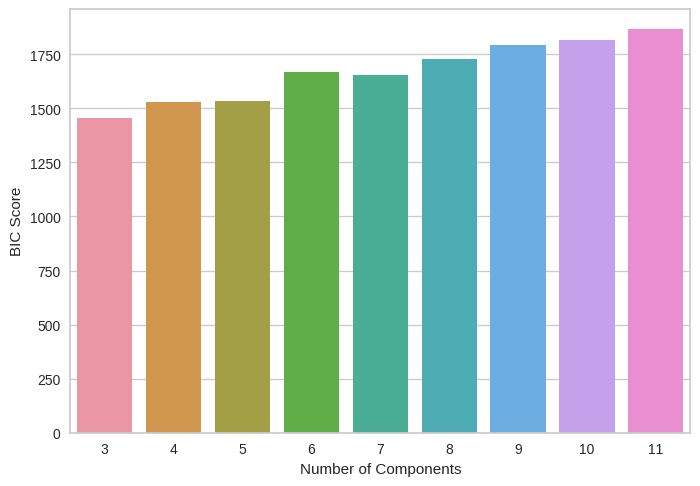

In [ ]:
bic_grid_search(tsne)

AIC Score: 6215.739275026712
BIC Score: 6285.933128597741
Silhouette coefficient: 0.35908285


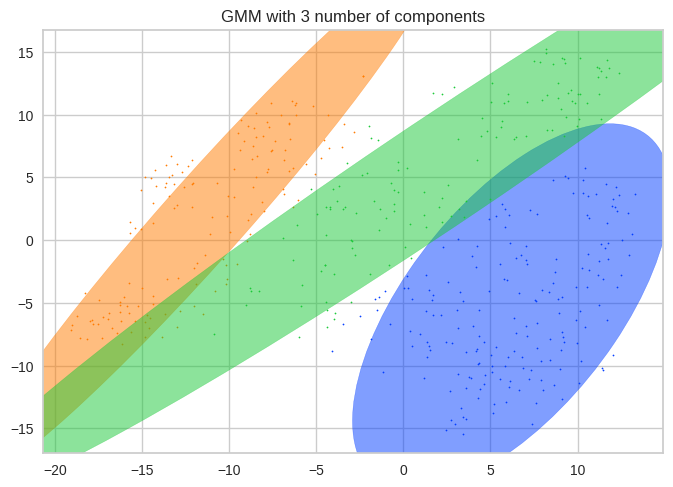

Unique clusters:  [0 1 2]


In [ ]:
# for GMM with t-sne data
probs, gmm_labels = gmm(tsne,3) # GMM on tsne-reduced data with optimal values
print("Unique clusters: ", np.unique(gmm_labels))

## Using DBSCAN

In [ ]:
def dbscan(data1, eps):
  '''
    Running DBSCAN with optimal parameters on the dataframe given
  '''
  # parameter values to test
  params_grid = {
      'eps': eps,
      'min_samples': [3, 5, 8, 9, 10, 15, 20, 30]
  }

  score = -1 # the best silhoutte score
  best_params = { # best set of parameters, initialized with fairly suitable values
      'eps': eps[0],
      'min_samples': 10
  }

  for params in ParameterGrid(params_grid): # to iterate and test all possible combinations of the values
      model = DBSCAN(**params) # created a DBSCAN model with the parameters given
      labels = model.fit_predict(data1) # fitting the model on the data

      # to check if there are at least two unique labels for the silhouette_score() function to work
      if len(np.unique(labels)) > 1:
          sscore = silhouette_score(data1, labels) # silhouette score
          if sscore > score: # if the new score is better, the new set of parameters are better
              score = sscore
              best_params = params

  print("Best set of parameters:", best_params)
  print("Best calculated silhouette score:", score)

  # running DBSCAN with optimal parameters
  model = DBSCAN(eps = best_params['eps'], min_samples = best_params['min_samples'])
  labels = model.fit_predict(data1) # fitting the model on the given data
  print('Number of clusters: ', np.unique(labels))
  # scatter plot with 2 features only, for DBSCAN clusters
  plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], c=labels, cmap='viridis')
  plt.title('DBSCAN Clustering')
  plt.colorbar()
  plt.show()


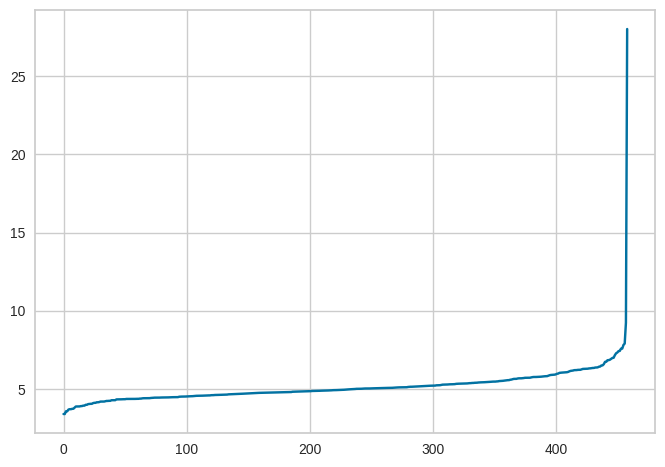

In [ ]:
# to get the minimum and maximum eps value to check from the graph, the point of consistent increase in the y-axis
knn = NearestNeighbors(n_neighbors=5).fit(data) # to create an instance of NearestNeighbors with k=5 and fit it to the original data
distances, indices = knn.kneighbors(data) # to compute the distances and indices of the k nearest neighbors for each data point
distances = np.sort(distances, axis=0) # to sort the distances along the rows to obtain distances in ascending order for each data point
plt.plot(distances[:, 1]) # to plot the distances to the second nearest neighbor for each data point
plt.show()

Best set of parameters: {'eps': 10, 'min_samples': 3}
Best calculated silhouette score: 0.713033733143475
Number of clusters:  [-1  0]


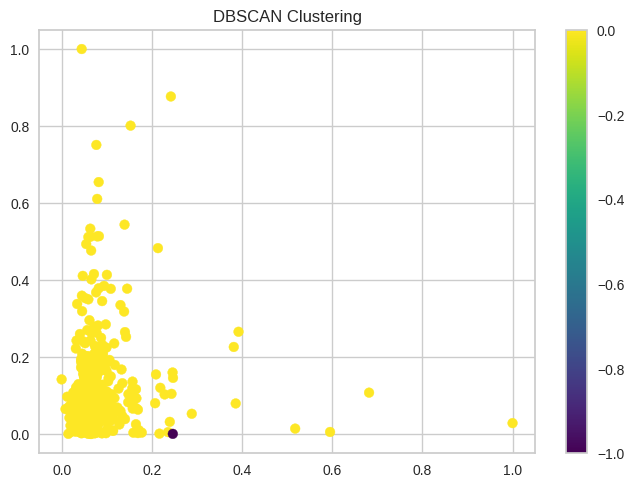

In [ ]:
dbscan(data, np.arange(8, 25, 2)) # eps is values in range 8-25 at every 2 step

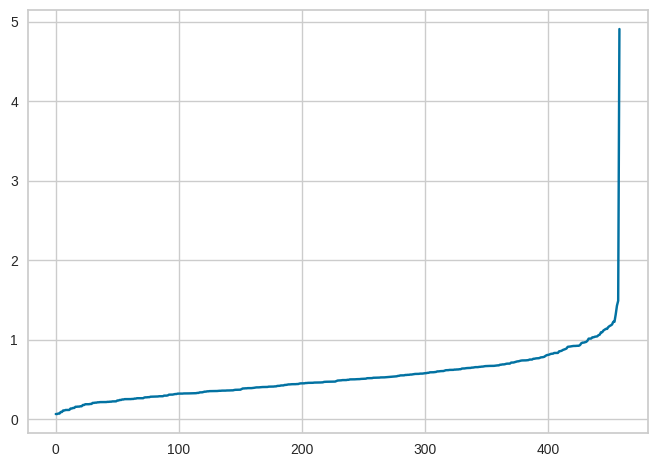

In [ ]:
# to get the minimum and maximum eps value to check from the graph, the point of consistent increase in the y-axis
knn = NearestNeighbors(n_neighbors=5).fit(reduced_data) # to create an instance of NearestNeighbors with k=5 and fit it to the original data
distances, indices = knn.kneighbors(reduced_data) # to compute the distances and indices of the k nearest neighbors for each data point
distances = np.sort(distances, axis=0) # to sort the distances along the rows to obtain distances in ascending order for each data point
plt.plot(distances[:, 1])
plt.show()

Best set of parameters: {'eps': 1.5000000000000002, 'min_samples': 3}
Best calculated silhouette score: 0.4053136426765488
Number of clusters:  [-1  0]


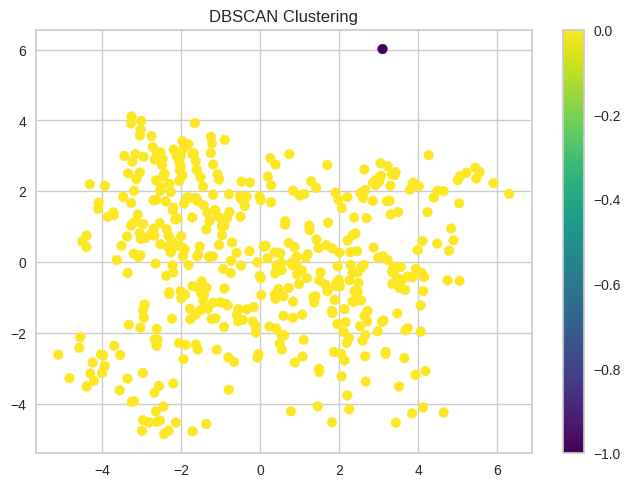

In [ ]:
dbscan(reduced_data, np.arange(1.2,5,0.1)) # for reduced dataset

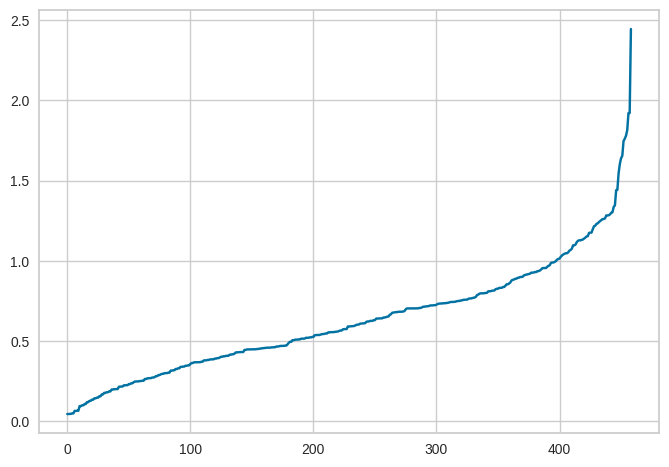

In [ ]:
# to get the minimum and maximum eps value to check from the graph, the point of consistent increase in the y-axis
knn = NearestNeighbors(n_neighbors=5).fit(tsne) # to create an instance of NearestNeighbors with k=5 and fit it to the original data
distances, indices = knn.kneighbors(tsne) # to compute the distances and indices of the k nearest neighbors for each data point
distances = np.sort(distances, axis=0) # to sort the distances along the rows to obtain distances in ascending order for each data point
plt.plot(distances[:, 1])
plt.show()

Best set of parameters: {'eps': 1.9249999999999978, 'min_samples': 8}
Best calculated silhouette score: 0.32044008
Number of clusters:  [-1  0  1  2  3  4  5]


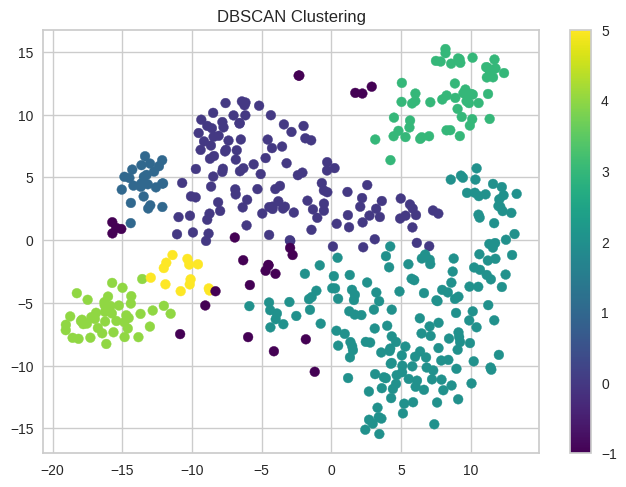

In [ ]:
dbscan(tsne, np.arange(1.3,2.5,0.025)) # for the tsne-reduced model

## Using BIRCH

In [ ]:
def birch(data1):
  '''
    Running BIRCH with optimal parameters on the dataframe given
  '''
  # grid of suitable parameter values to test for
  params_grid = {
      'threshold': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0],
      'n_clusters' : [1,2,3,4,5,6,7,8,9,10],
      'branching_factor': [3, 4, 5, 10, 20, 30, 40]
  }

  score = -1 # the best silhoutte score
  best_params = { # best set of parameters, initialized with fairly suitable values
      'threshold': 0.1,
      'n_clusters' : 3,
      'branching_factor': 5
  }

  for params in ParameterGrid(params_grid): # to iterate and test all possible combinations of the values
      model = Birch(**params) # created a BIRCH model with the parameters given
      labels = model.fit_predict(data1) # fitting the model on the data

      # to check if there are at least two unique labels for the silhouette_score() function to work
      if len(np.unique(labels)) > 1:
          sscore = silhouette_score(data1, labels) # silhouette score
          if sscore > score: # if the new score is better, the new set of parameters are better
              score = sscore
              best_params = params

  print("Best set of parameters:", best_params)
  print("Best calculated silhouette score:", score)

  # running the model with optimal parameters
  model = Birch(branching_factor = best_params['branching_factor'], n_clusters = best_params['n_clusters'], threshold = best_params['threshold'])
  labels = model.fit_predict(data1) # assign each data point to a cluster and output labels
  print('Number of clusters: ', np.unique(labels))

  # scatter plot with 2 features only, for BIRCH clusters
  plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], c=labels, cmap='viridis')
  plt.title('BIRCH Clustering')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.show()

Best set of parameters: {'branching_factor': 3, 'n_clusters': 2, 'threshold': 0.01}
Best calculated silhouette score: 0.12224750546814411
Number of clusters:  [0 1]


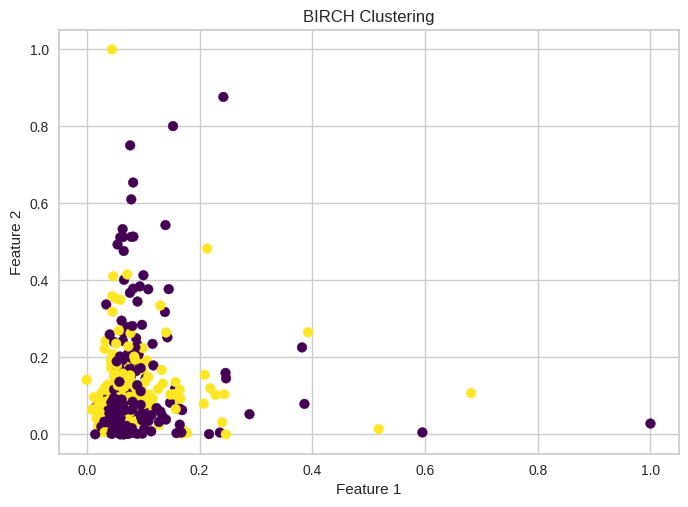

In [ ]:
birch(data) # BIRCH on the original dataset

Best set of parameters: {'branching_factor': 4, 'n_clusters': 2, 'threshold': 2.0}
Best calculated silhouette score: 0.40531364261161384
Number of clusters:  [0 1]


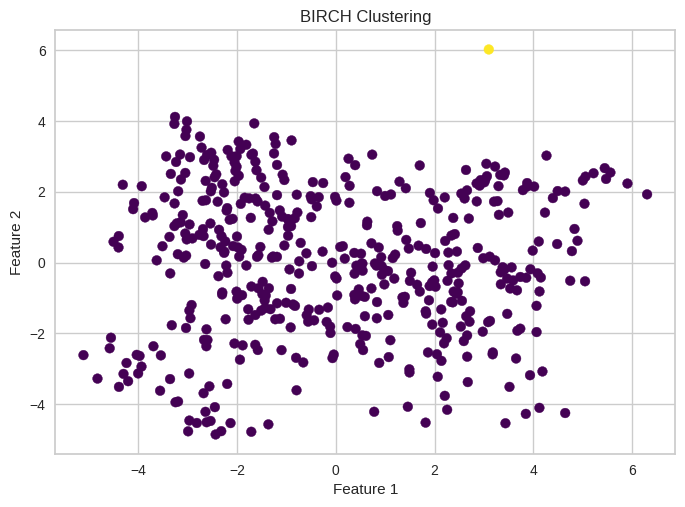

In [ ]:
birch(reduced_data) # BIRCH on the PCA-reduced dataset

Best set of parameters: {'branching_factor': 4, 'n_clusters': 4, 'threshold': 1.0}
Best calculated silhouette score: 0.44792065
Number of clusters:  [0 1 2 3]


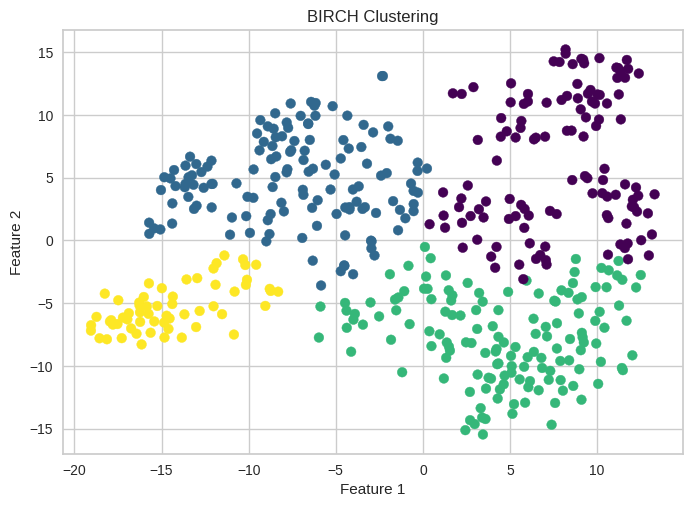

In [ ]:
birch(tsne) # BIRCH on the t-SNE-reduced dataset